In [1]:
%load_ext autoreload
%autoreload 2

# %config InlineBackend.figure_formats = ['svg']

from IPython.display import display, Markdown

import sys, os
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import scipy.stats as stats


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import pickle

import noise_models as noise
import thermo_models as thermo

import fig_plot as fplot
import model_fitting as fit

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

This file uses the model parameters found from fitting to predict the antibody distributions for the phosphorylated substrate.

In [2]:

# label = "220520_pushpull"
label = '220810_secondlayer'
# 
df_params = pd.read_csv("../data/"+label+"/model_params.csv", sep=',', engine='python', index_col='name')

display(df_params)

val  val_min  val_max
name                                             
phospho_sigma          1.130701      0.0      0.0
kinase2_phospho_sigma  0.707599      0.0      0.0
kin2_bg_phospho_rate  -1.020328      0.0      0.0
sub2_bg_phospho_rate  -1.867567      0.0      0.0
kinase1_wt            -0.641238      0.0      0.0
L+A                    3.151006      0.0      0.0
pptase1_wt            -0.014700      0.0      0.0
kinase2_wt            -0.380627      0.0      0.0
SH2                    2.849957      0.0      0.0
nb_SH2                 3.118328      0.0      0.0
kinase2_dead          -1.221825      0.0      0.0
1xSH2                  3.028006      0.0      0.0

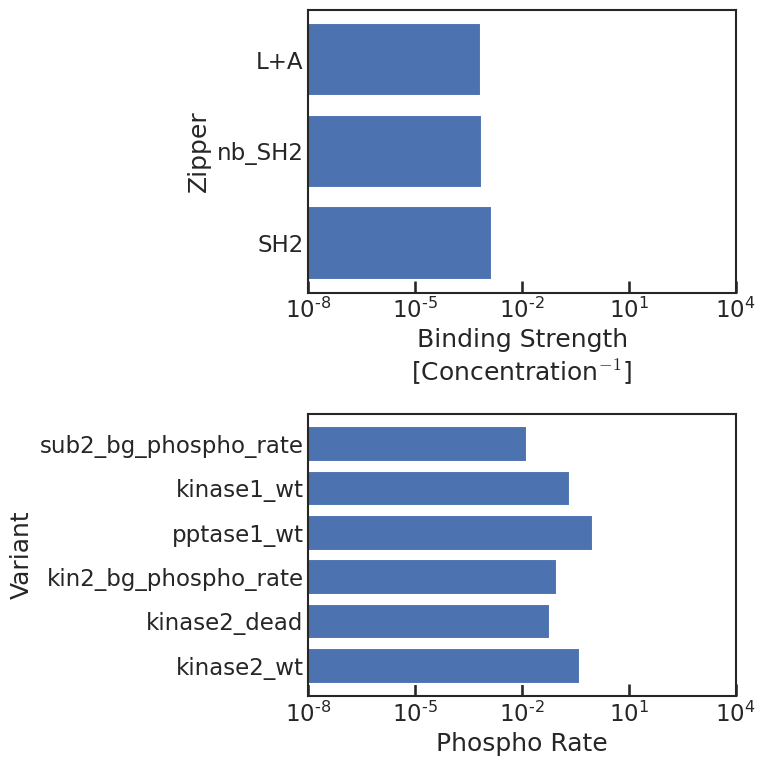

In [6]:
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


ax = ax1

affinities = ['SH2', 'nb_SH2', 'L+A', 'E+A', 'E+E', 'pptase_non-binding', 'kinase_non-binding']

labels = [x for x in affinities if x in df_params.index.values]


vals = 1.0 / 10**df_params.loc[labels, 'val']

y_low = vals-1.0/10**df_params.loc[labels, 'val_max']
y_high = 1.0/10**df_params.loc[labels, 'val_min']-vals

ax.barh(labels, vals, xerr=(y_low, y_high))



ax.set_xscale('log')
ax.set_ylabel("Zipper")
ax.set_xlabel("Binding Strength\n[Concentration$^{-1}$]")

ax.set_xlim(1e-8, 1e4)

ax = ax2

activities = ['kinase2_wt', 'kinase2_dead', 'kin2_bg_phospho_rate', 'pptase1_wt', 'pptase_wt', 'pptase_weak', 'pptase_dead',
               'kinase1_wt', 'kinase_wt', '419', '375', 'kinase_dead', 'sub_bg_phospho_rate', 'sub2_bg_phospho_rate', 'bg_flouresce']



labels = [x for x in activities if x in df_params.index.values]

vals = 10**df_params.loc[labels, 'val']

y_low = vals-10**df_params.loc[labels, 'val_min']
y_high = 10**df_params.loc[labels, 'val_max']-vals

ax.barh(labels, vals, xerr=(y_low, y_high))



ax.set_xscale('log')
ax.set_ylabel("Variant")
ax.set_xlabel("Phospho Rate")

ax.set_xlim(1e-8, 1e4)


plt.tight_layout()

plt.show()

In [4]:
df_data = pd.read_csv("../data/"+label+"/model_predictions.csv", sep='\s*,\s*', index_col=[0, 1])
display(df_data)

df_dataset_key = pd.read_csv("../data/"+label+"/dataset_key.csv", sep='\s*,\s*', engine='python').set_index("exp_name")
# df_dataset_key = df_dataset_key.query("model!='pushpull'")
display(df_dataset_key)

df_anti2GFP_key = pd.read_csv("../data/"+label+"/MOCU_key.csv", sep='\s*,\s*', engine='python').set_index("component")
display(df_anti2GFP_key)

df_phospho_empty = pd.read_csv("../data/{}/{}.csv".format(label, df_anti2GFP_key.loc['empty_phospho', 'file_name']))
empty_anti_vals = df_phospho_empty[df_anti2GFP_key.loc['empty_phospho', 'anti_col_name']].values
empty_anti_vals = empty_anti_vals[empty_anti_vals > 0.0]
empty_GFP_vals = df_phospho_empty[df_anti2GFP_key.loc['empty_phospho', 'GFP_col_name']].values
empty_GFP_vals = empty_GFP_vals[empty_GFP_vals > 0.0]

df_phospho_nonempty = pd.read_csv("../data/{}/{}.csv".format(label, df_anti2GFP_key.loc['phospho', 'file_name']))
nonempty_anti_vals = df_phospho_nonempty[df_anti2GFP_key.loc['phospho', 'anti_col_name']].values
nonempty_anti_vals = nonempty_anti_vals[nonempty_anti_vals > 0.0]
nonempty_GFP_vals = df_phospho_nonempty[df_anti2GFP_key.loc['phospho', 'GFP_col_name']].values
nonempty_GFP_vals = nonempty_GFP_vals[nonempty_GFP_vals > 0.0]


/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


kinase_anti_exp  phospho_anti_exp  pptase_anti_exp  \
exp_name    cell_index                                                       
two_layer   0               1132.644775       1478.883301      1425.913330   
            4               1442.491699        635.542847        88.930649   
            5               8793.622070        812.160950       146.514679   
            6               1792.821777       2214.880127        89.025887   
            8                201.405777       3024.554932       153.496933   
...                                 ...               ...              ...   
high pptase 10990           1337.849976        346.672455       184.115448   
            10991           4933.886230       1592.830200     10112.708010   
            10992          38488.914060        636.693359       564.738708   
            10993           1320.361694       3943.709717       568.285217   
            10994          11779.988280      10165.728520      5409.261230   

                        substrate_anti_exp  kinase2_anti_exp  \
exp_name    cell_index                                         
two_layer   0                  2399.792236       1518.167847   
            4                   523.847473       1035.239136   
            5                  7245.374023       2681.130859   
            6                  6909.660156       2263.580078   
            8                  3585.488770        449.934784   
...                                    ...               ...   
high pptase 10990              7806.669922        452.051483   
            10991              4424.474121       4655.105469   
            10992              7059.206055        983.965027   
            10993              3229.053955       1279.004761   
            10994             12926.014650       3230.778564   

                        kinase2_phospho_anti_exp  phospho_GFP_infer  \
exp_name    cell_index                                                
two_layer   0                        1701.817749        7374.915290   
            4                        5222.672852        4142.932616   
            5                       18908.003910        4898.079478   
            6                       14202.298830        9717.039625   
            8                        1672.440430       12020.611395   
...                                          ...                ...   
high pptase 10990                    2441.281006        2738.883044   
            10991                    2217.132080        7758.325188   
            10992                    7953.897461        4148.052178   
            10993                    4637.126465       14408.426347   
            10994                    4563.793945       27505.091708   

                        substrate_GFP_infer  kinase_GFP_infer  \
exp_name    cell_index                                          
two_layer   0                  79420.305908      14467.199881   
            4                  24799.658349      17623.765918   
            5                 184898.125267      77061.869262   
            6                 178309.792432      21045.775626   
            8                 107966.060818       3533.754738   
...                                     ...               ...   
high pptase 10990             195755.839533      16573.148201   
            10991             126800.356585      48083.641475   
            10992             181253.698045     257124.755717   
            10993              99657.742185      16396.116297   
            10994             287870.647047      97830.636472   

                        pptase_GFP_infer  ...  pptase_GFP_denoise  \
exp_name    cell_index                    ...                       
two_layer   0               18909.544251  ...        18675.791484   
            4                2335.628088  ...         2572.185964   
            5                3402.788514  ...         3178.427362   
            6                2337.513133  ...         2572.84

file_name               model kinase_variant kinase_zipper  \
exp_name                                                                    
two_layer     low pptase           two_layer     kinase1_wt           L+A   
nb SH2            nb SH2           two_layer     kinase1_wt           L+A   
no WT1            no WT1  two_layer_nowriter     kinase1_wt           L+A   
WT2 dead        WT2 dead           two_layer     kinase1_wt           L+A   
mono                mono           two_layer     kinase1_wt           L+A   
no pptase      no pptase  two_layer_noeraser     kinase1_wt           L+A   
med pptase    med pptase           two_layer     kinase1_wt           L+A   
high pptase  high pptase           two_layer     kinase1_wt           L+A   

            pptase_variant pptase_zipper kinase2_variant kinase2_zipper  \
exp_name                                                                  
two_layer       pptase1_wt           L+A      kinase2_wt            SH2   
nb SH2          pptase1_wt           L+A      kinase2_wt         nb_SH2   
no WT1          pptase1_wt           L+A      kinase2_wt            SH2   
WT2 dead        pptase1_wt           L+A    kinase2_dead            SH2   
mono            pptase1_wt           L+A      kinase2_wt          1xSH2   
no pptase       pptase1_wt           L+A      kinase2_wt            SH2   
med pptase      pptase1_wt           L+A      kinase2_wt            SH2   
high pptase     pptase1_wt           L+A      kinase2_wt            SH2   

             kinase2_phospho_factor  substrate_phospho_factor kinase_col  \
exp_name                                                                   
two_layer                         3                  1.000000        WT1   
nb SH2                            3                  1.000000        WT1   
no WT1                            3                  1.000000        WT1   
WT2 dead                          3                  1.000000        WT1   
mono                              3                  0.333333        WT1   
no pptase                         3                  1.000000        WT1   
med pptase                        3                  1.000000        WT1   
high pptase                       3                  1.000000        WT1   

            pptase_col kinase2_col kinase2_phospho_col substrate_col  \
exp_name                                                               
two_layer       pptase         ST1                SpT1           ST2   
nb SH2          pptase         ST1                SpT1           ST2   
no WT1          pptase         ST1                SpT1           ST2   
WT2 dead        pptase         ST1                SpT1           ST2   
mono            pptase         ST1                SpT1           ST2   
no pptase       pptase         ST1                SpT1           ST2   
med pptase      pptase         ST1                SpT1           ST2   
high pptase     pptase         ST1                SpT1           ST2   

            phospho_col  
exp_name                 
two_layer          SpT2  
nb SH2             SpT2  
no WT1             SpT2  
WT2 dead           SpT2  
mono               SpT2  
no pptase          SpT2  
med pptase         SpT2  
high pptase        SpT2

file_name anti_col_name GFP_col_name
component                                                    
empty_substrate                BFP           ST2          GFP
empty_phospho             BFP_SpT2          SpT2      mCherry
empty_kinase                   BFP           WT1          GFP
empty_pptase                   BFP        pptase          GFP
empty_kinase2                  BFP           ST1          GFP
empty_kinase2_phospho          BFP          SpT1          GFP
substrate                 ST2 MOCU           ST2          GFP
phospho                  SpT2 MOCU          SpT2      mCherry
kinase                    WT1 MOCU           WT1          GFP
pptase                 pptase MOCU        pptase          GFP
kinase2                   ST1 MOCU           ST1          GFP
kinase2_phospho          SpT1 MOCU          SpT1          GFP

KS for empty and activated controls: 0.7615423179241427


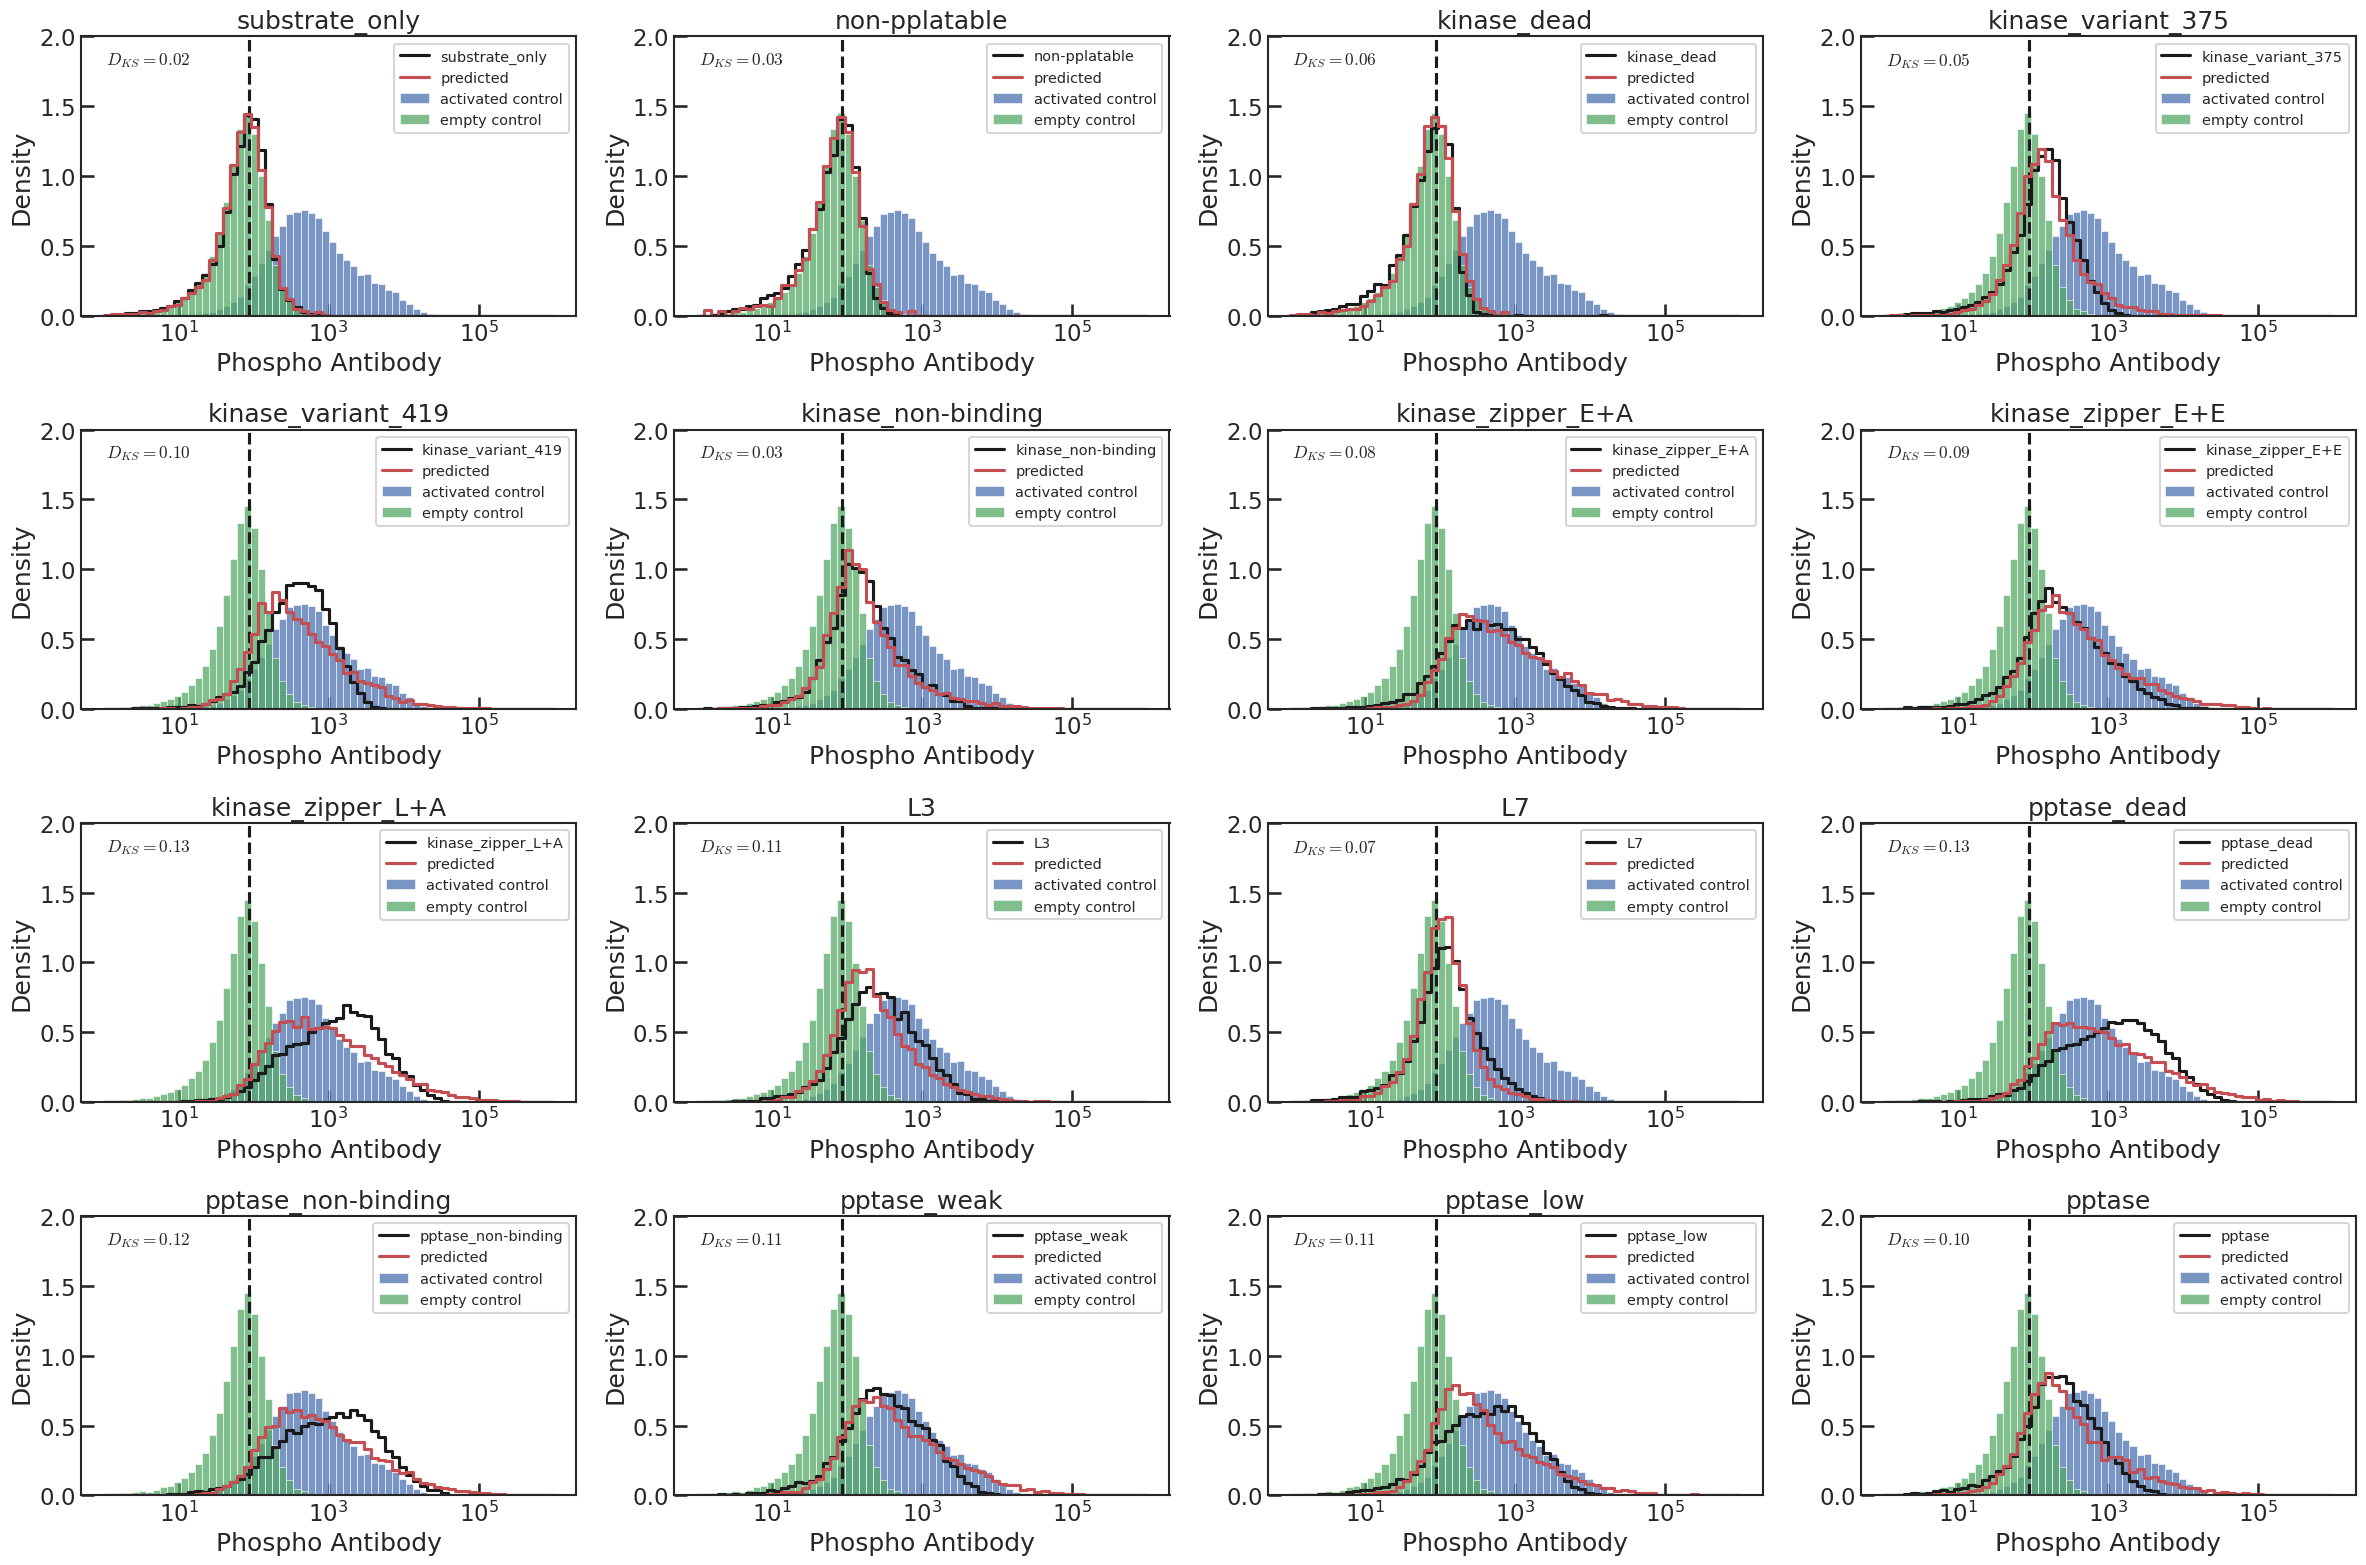

In [36]:

(ks, pval) = stats.ks_2samp(nonempty_anti_vals, empty_anti_vals)

print("KS for empty and activated controls:", ks)

binrange = (0, 6)

fig = plt.figure(figsize=(24, 16))

# which data set to put on each axis
ax_dict = {'substrate_only': 1, 'non-pplatable': 2, 'kinase_dead': 3, 'kinase_variant_375': 4, 'kinase_variant_419': 5,
          'kinase_non-binding': 6, 'kinase_zipper_E+A': 7, 'kinase_zipper_E+E': 8, 'kinase_zipper_L+A': 9, 'L3': 10, "L7": 11,
           'pptase_dead': 12, 'pptase_non-binding': 13, 'pptase_weak': 14, 'pptase_low': 15, 'pptase': 16}


for exp_name, row in df_dataset_key.iterrows():
    
    if exp_name not in ax_dict:
        continue
        
    df_tmp = df_data.query("exp_name==@exp_name")
    
    ax = fig.add_subplot(4, 4, ax_dict[exp_name])
    
    ax.set_title(exp_name)
        
    sns.histplot(df_tmp['phospho_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=exp_name, element='step', fill=False, color='k', stat='density')
    sns.histplot(df_tmp['phospho_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(nonempty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')
    
    ax.vlines(empty_anti_vals.mean(), ymin=0, ymax=2.0, color='k', ls='--')

    ax.set_xlabel("Phospho Antibody")

    ax.set_ylim(0, 2.0)
    
    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')

    (ks, pval) = stats.ks_2samp(df_tmp['phospho_anti_exp'], df_tmp['phospho_anti_predict'])
        
    ax.text(0.05, 0.95, r"$D_{{KS}}={:.2f}$".format(ks), transform=ax.transAxes, fontsize='x-small', ha='left', va='top')
        
    
    df_dataset_key.loc[exp_name, 'KS_stat'] = ks
    
plt.tight_layout()

plt.show()


KS for empty and activated controls: 0.7615423179241427


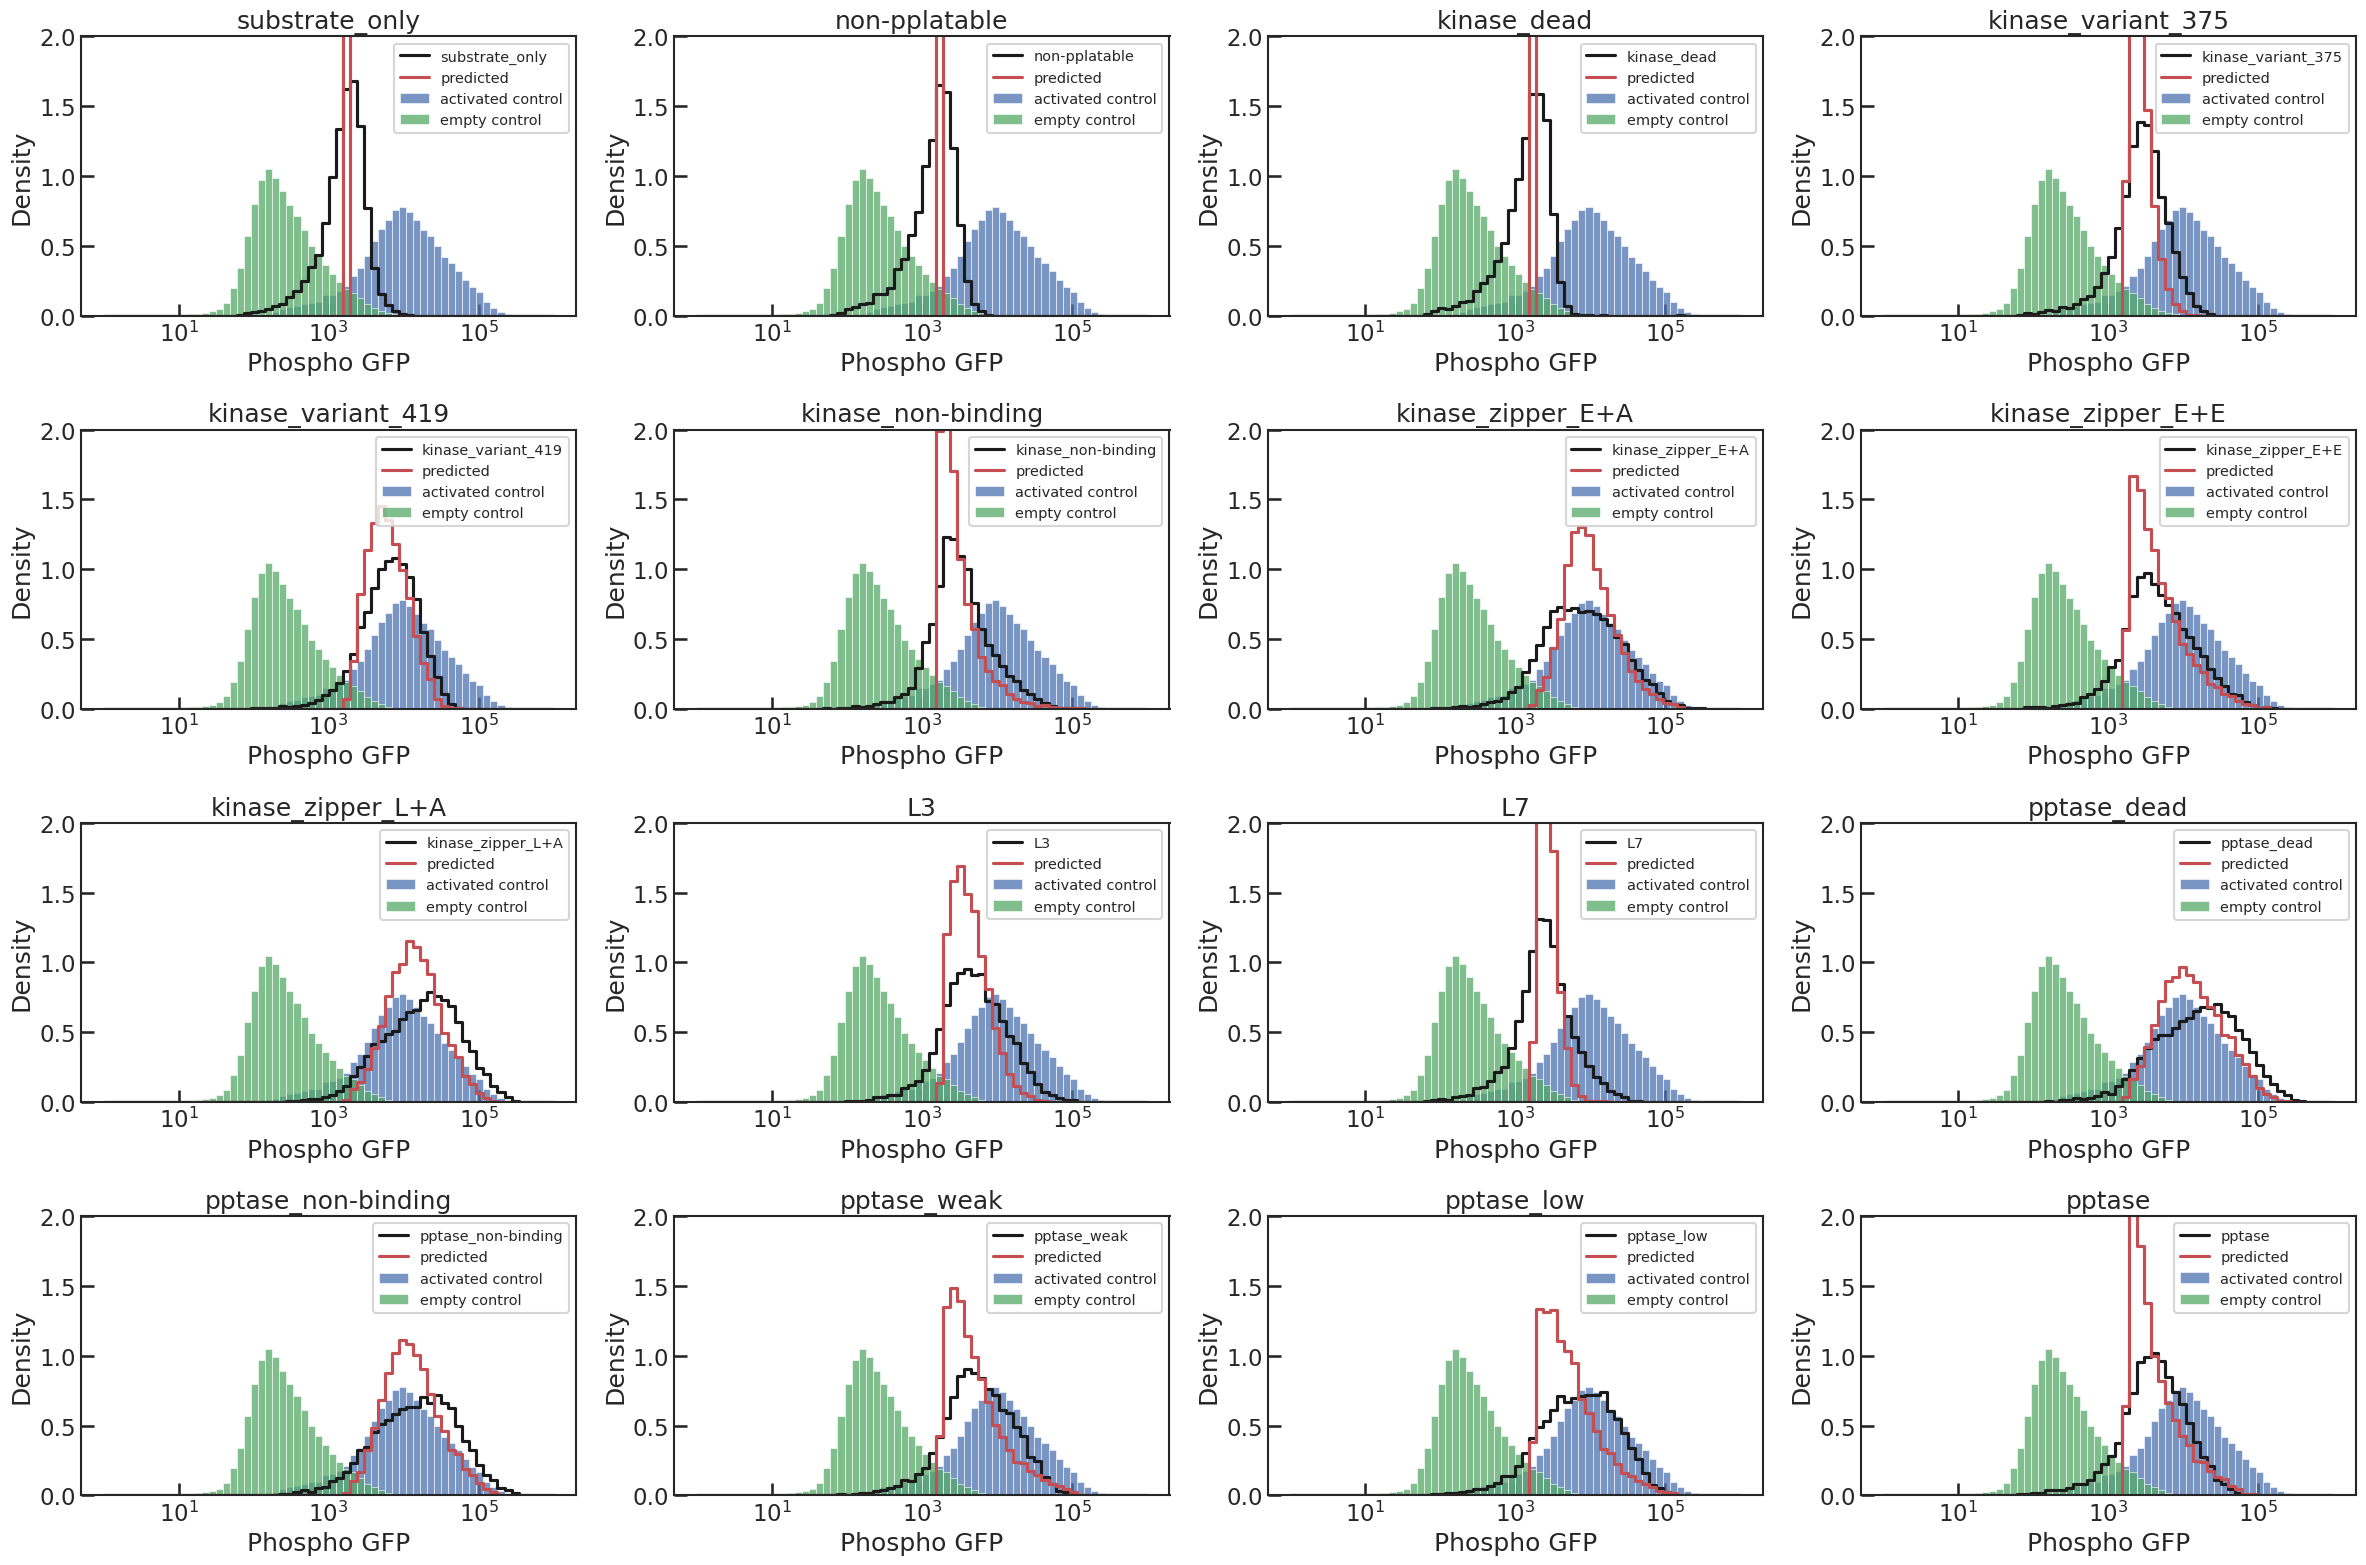

In [15]:
# Note: predicted GFP values don't need to match inferred GFP values because predictions lack noise
(ks, pval) = stats.ks_2samp(nonempty_anti_vals, empty_anti_vals)

print("KS for empty and activated controls:", ks)

binrange = (0, 6)

fig = plt.figure(figsize=(24, 16))

# which data set to put on each axis
ax_dict = {'substrate_only': 1, 'non-pplatable': 2, 'kinase_dead': 3, 'kinase_variant_375': 4, 'kinase_variant_419': 5,
          'kinase_non-binding': 6, 'kinase_zipper_E+A': 7, 'kinase_zipper_E+E': 8, 'kinase_zipper_L+A': 9, 'L3': 10, "L7": 11,
           'pptase_dead': 12, 'pptase_non-binding': 13, 'pptase_weak': 14, 'pptase_low': 15, 'pptase': 16}


for exp_name, row in df_dataset_key.iterrows():
    
    if exp_name not in ax_dict:
        continue
        
    df_tmp = df_data.query("exp_name==@exp_name").dropna()
    
    ax = fig.add_subplot(4, 4, ax_dict[exp_name])
    
    ax.set_title(exp_name)
        
    sns.histplot(df_tmp['phospho_GFP_infer'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=exp_name, element='step', fill=False, color='k', stat='density')
    sns.histplot(df_tmp['phospho_GFP_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(nonempty_GFP_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_GFP_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho GFP")
    
    ax.set_ylim(0, 2.0)

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')

#     (ks, pval) = stats.ks_2samp(df_tmp['phospho_GFP_infer'], df_tmp['phospho_GFP_predict'])
        
#     MSE = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_predict']))**2)
#     var = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_infer']).mean())**2)
#     R2 = 1 - MSE/var
        
#     ax.text(0.05, 0.95, r"$D_{{KS}}={:.2f}$".format(ks), transform=ax.transAxes, fontsize='x-small', ha='left', va='top')
        
    
#     df_dataset_key.loc[exp_name, 'KS_stat'] = ks
#     df_dataset_key.loc[exp_name, 'R2_stat'] = R2
    
plt.tight_layout()

plt.show()


KS for empty and activated controls: 0.9764978049373195


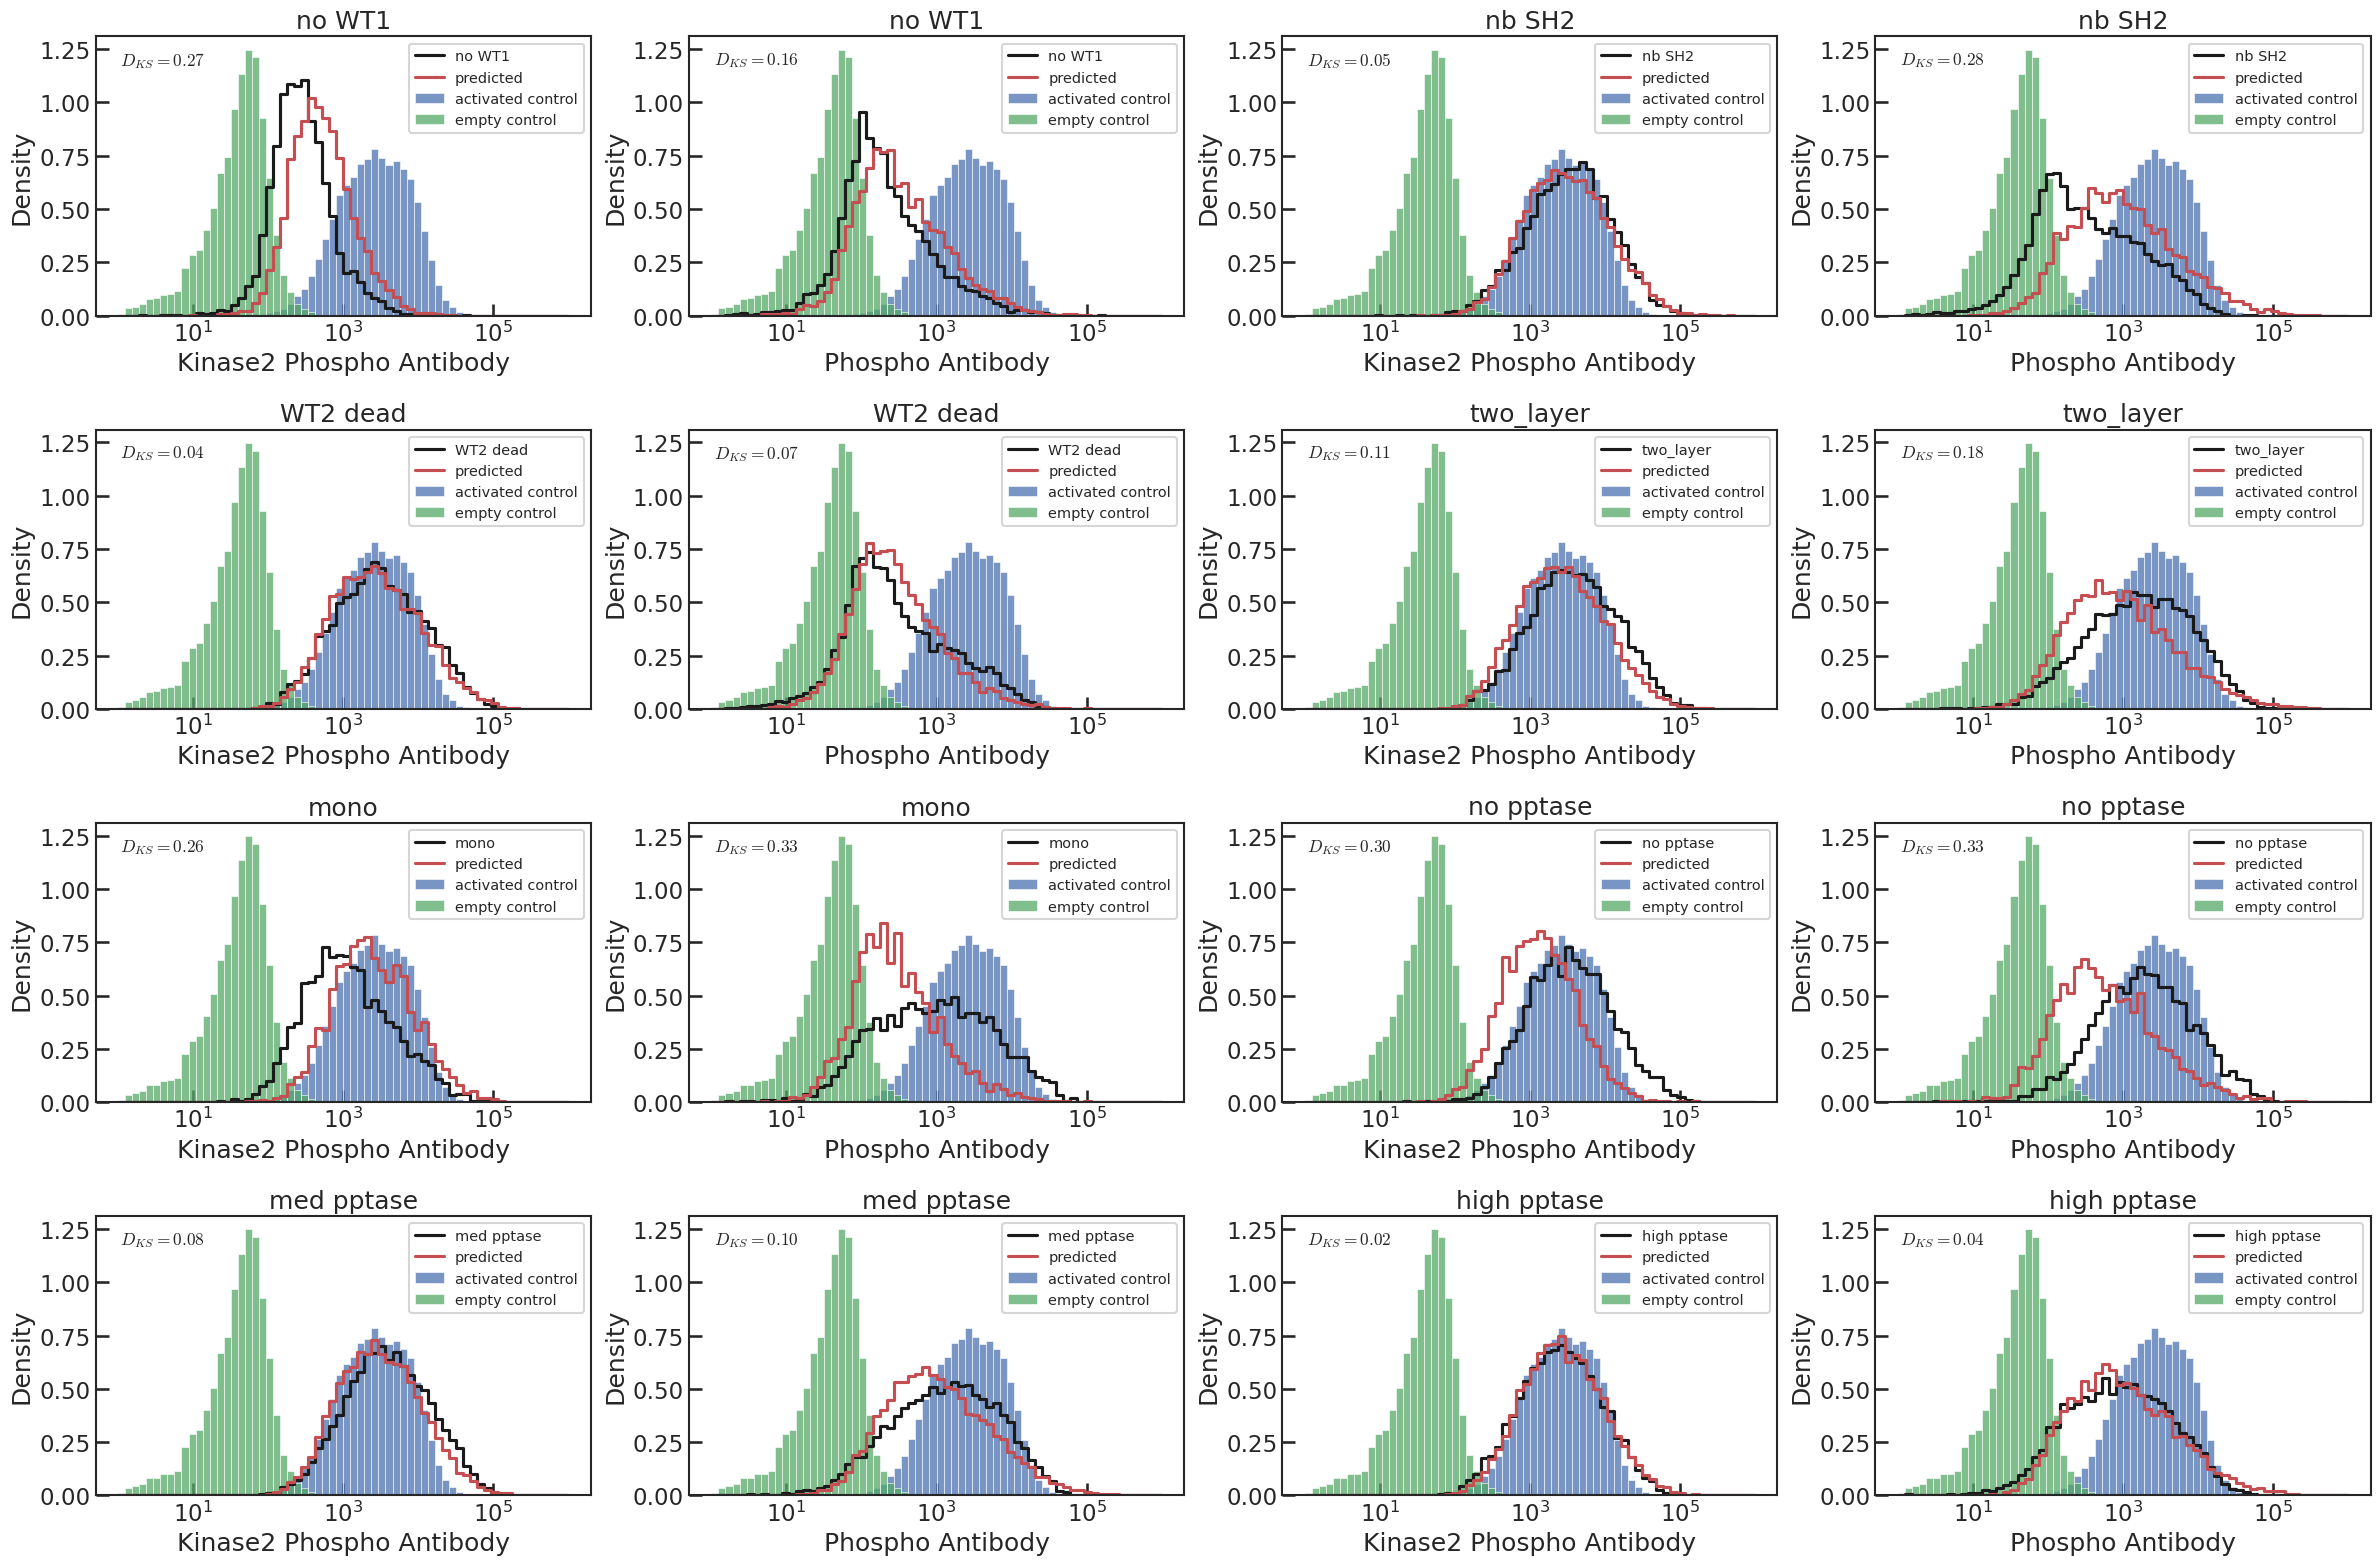

In [5]:

(ks, pval) = stats.ks_2samp(nonempty_anti_vals, empty_anti_vals)

print("KS for empty and activated controls:", ks)

binrange = (0, 6)

fig = plt.figure(figsize=(24, 16))

# which data set to put on each axis
ax_dict = {'no WT1': 1, 'nb SH2': 2, 'WT2 dead': 3, 'two_layer': 4, 'mono': 5, 'no pptase': 6, 'med pptase': 7, 'high pptase': 8}


for exp_name, row in df_dataset_key.iterrows():
    
        
    if exp_name not in ax_dict:
        continue
        
    df_tmp = df_data.query("exp_name==@exp_name").dropna()

    
    ax = fig.add_subplot(4, 4, 2*(ax_dict[exp_name]-1)+2)
    
    ax.set_title(exp_name)
        
    sns.histplot(df_tmp['phospho_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=exp_name, element='step', fill=False, color='k', stat='density')
    sns.histplot(df_tmp['phospho_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(nonempty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')

    (ks, pval) = stats.ks_2samp(df_tmp['phospho_anti_exp'], df_tmp['phospho_anti_predict'])
        
#     MSE = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_predict']))**2)
#     var = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_infer']).mean())**2)
#     R2 = 1 - MSE/var
        
    ax.text(0.05, 0.95, r"$D_{{KS}}={:.2f}$".format(ks), transform=ax.transAxes, fontsize='x-small', ha='left', va='top')
       
    ax = fig.add_subplot(4, 4, 2*(ax_dict[exp_name]-1)+1)
    
    ax.set_title(exp_name)
        
    sns.histplot(df_tmp['kinase2_phospho_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=exp_name, element='step', fill=False, color='k', stat='density')
    sns.histplot(df_tmp['kinase2_phospho_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(nonempty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Kinase2 Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')

    (ks, pval) = stats.ks_2samp(df_tmp['kinase2_phospho_anti_exp'], df_tmp['kinase2_phospho_anti_predict'])
        
#     MSE = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_predict']))**2)
#     var = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_infer']).mean())**2)
#     R2 = 1 - MSE/var
        
    ax.text(0.05, 0.95, r"$D_{{KS}}={:.2f}$".format(ks), transform=ax.transAxes, fontsize='x-small', ha='left', va='top')
        
    
    df_dataset_key.loc[exp_name, 'KS_stat'] = ks
#     df_dataset_key.loc[exp_name, 'R2_stat'] = R2
    
plt.tight_layout()

plt.show()


KS for empty and activated controls: 0.9764978049373195


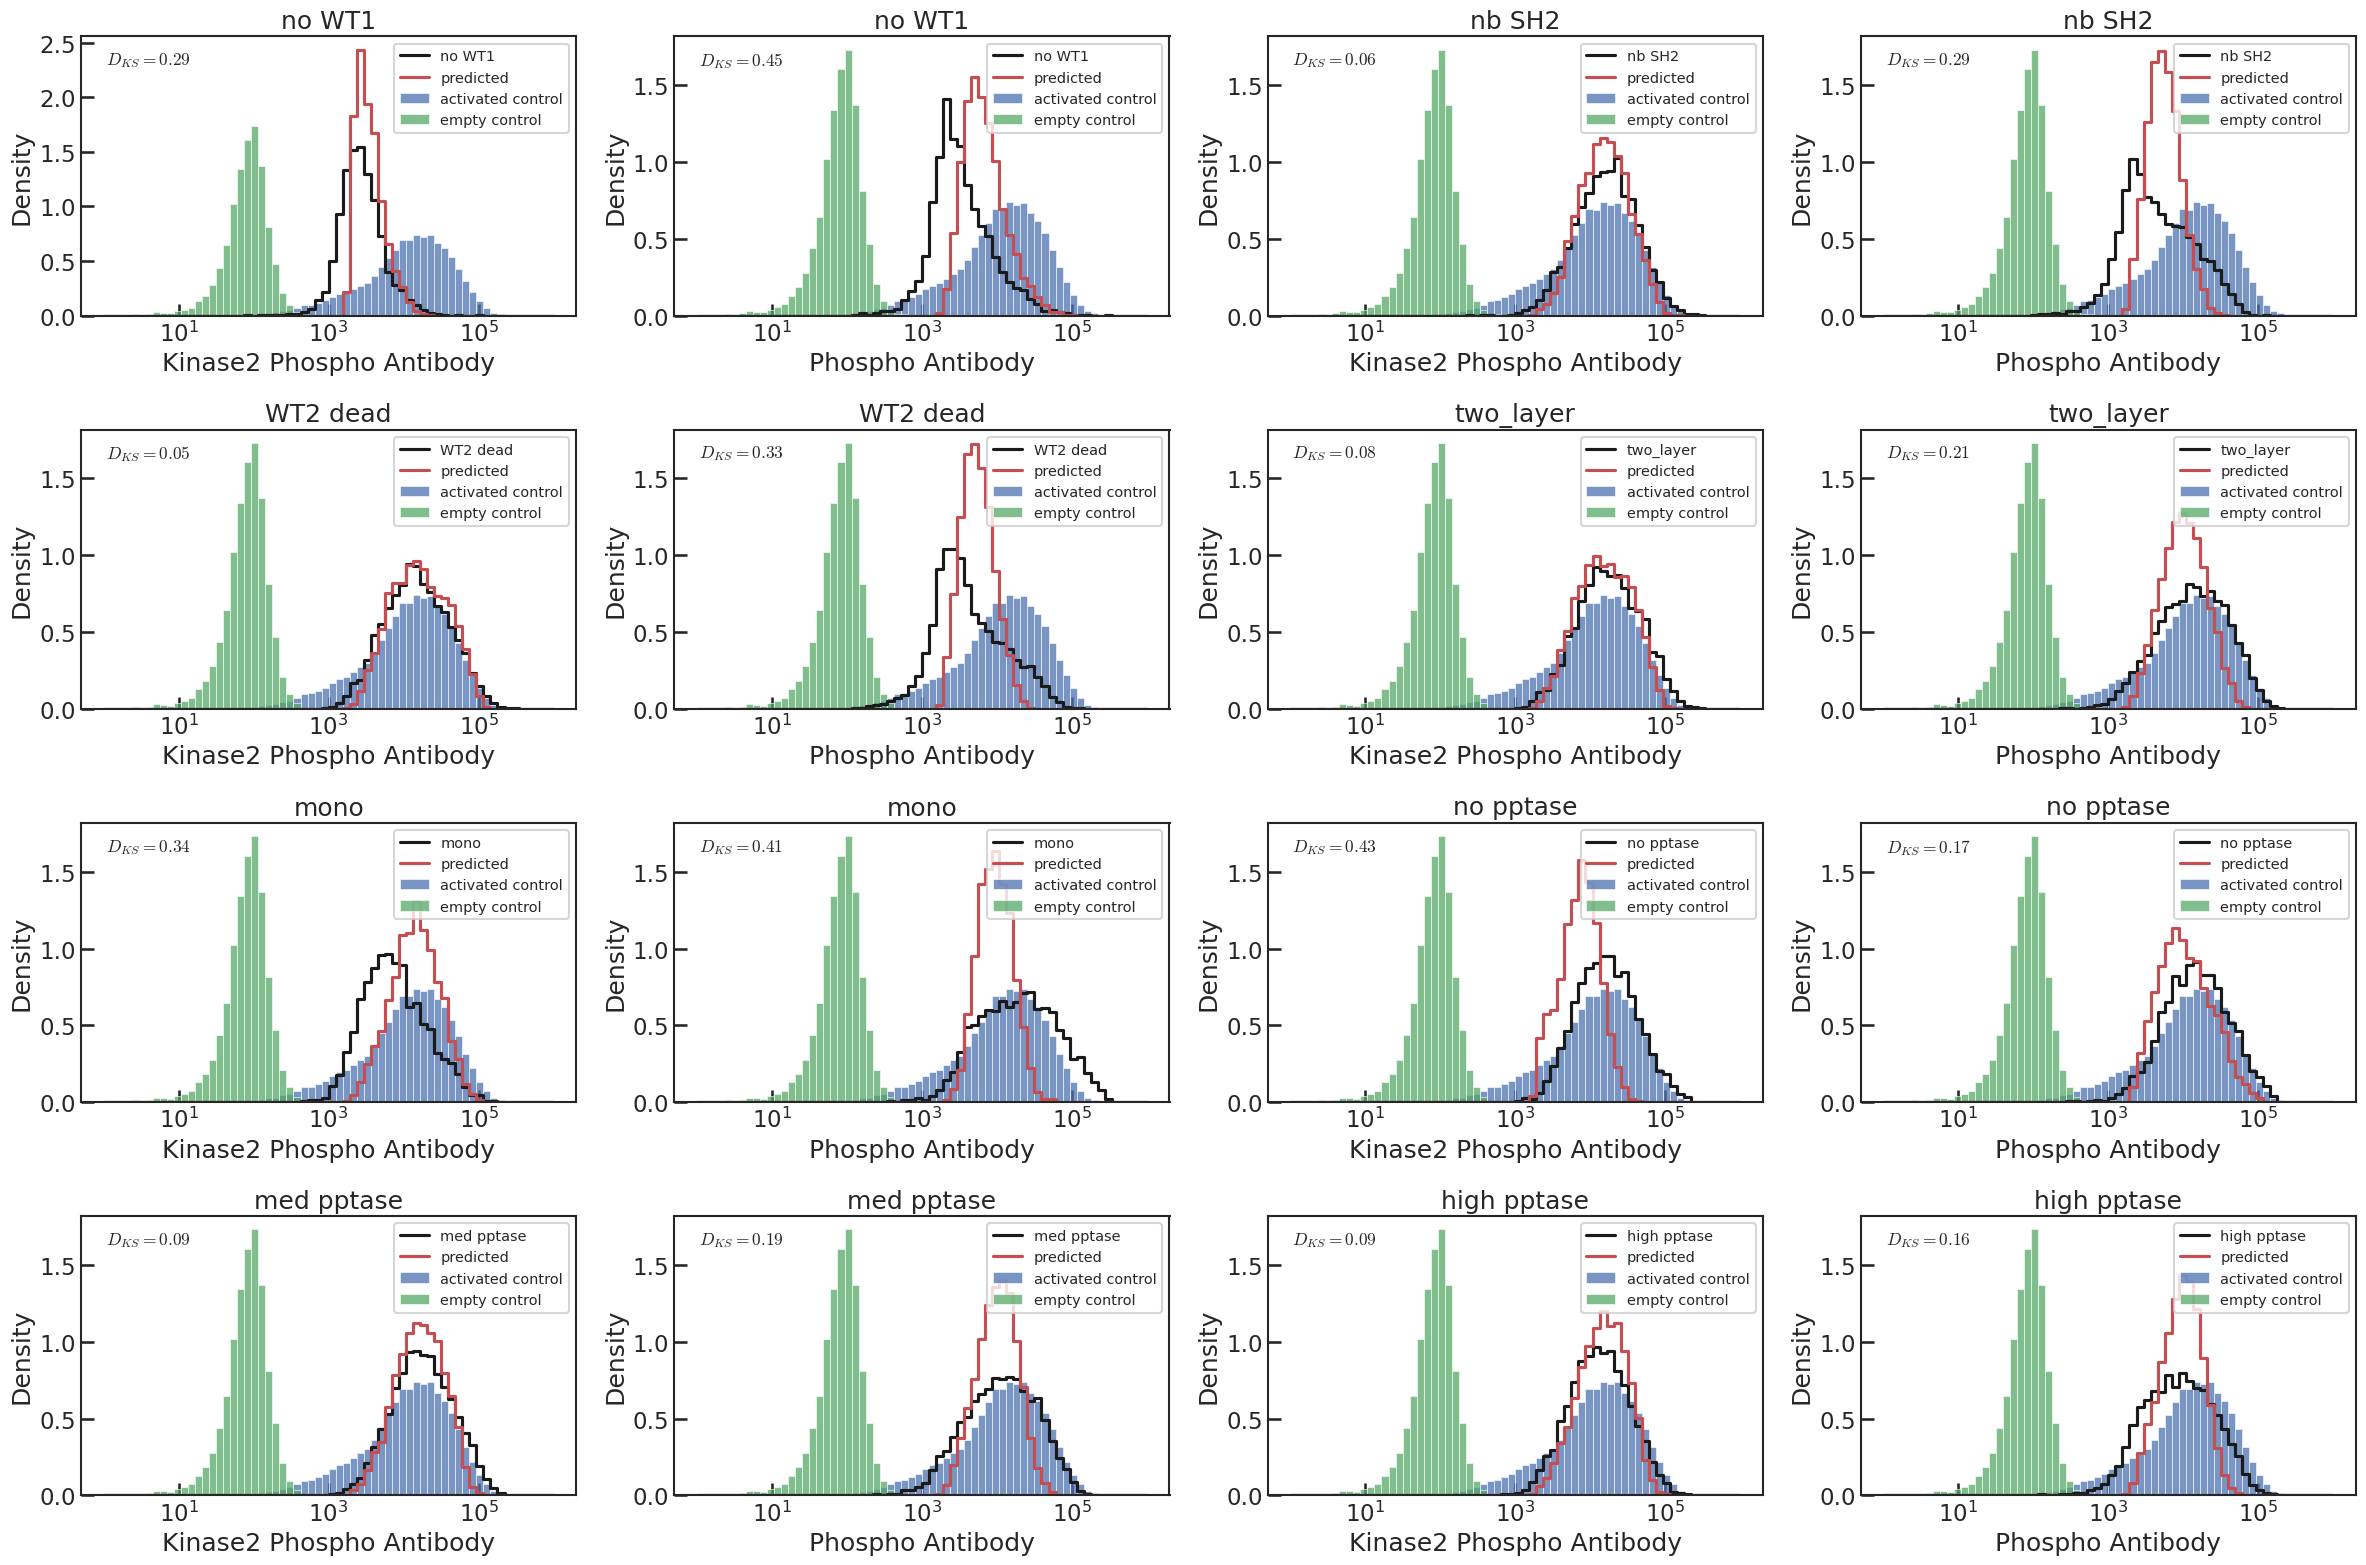

In [22]:

(ks, pval) = stats.ks_2samp(nonempty_anti_vals, empty_anti_vals)

print("KS for empty and activated controls:", ks)

binrange = (0, 6)

fig = plt.figure(figsize=(24, 16))

# which data set to put on each axis
ax_dict = {'no WT1': 1, 'nb SH2': 2, 'WT2 dead': 3, 'two_layer': 4, 'mono': 5, 'no pptase': 6, 'med pptase': 7, 'high pptase': 8}


for exp_name, row in df_dataset_key.iterrows():
    
        
    if exp_name not in ax_dict:
        continue
        
    df_tmp = df_data.query("exp_name==@exp_name").dropna()

    
    ax = fig.add_subplot(4, 4, 2*(ax_dict[exp_name]-1)+2)
    
    ax.set_title(exp_name)
        
    sns.histplot(df_tmp['phospho_GFP_infer'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=exp_name, element='step', fill=False, color='k', stat='density')
    sns.histplot(df_tmp['phospho_GFP_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(nonempty_GFP_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_GFP_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')

    (ks, pval) = stats.ks_2samp(df_tmp['phospho_GFP_infer'], df_tmp['phospho_GFP_predict'])
        
#     MSE = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_predict']))**2)
#     var = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_infer']).mean())**2)
#     R2 = 1 - MSE/var
        
    ax.text(0.05, 0.95, r"$D_{{KS}}={:.2f}$".format(ks), transform=ax.transAxes, fontsize='x-small', ha='left', va='top')
       
    ax = fig.add_subplot(4, 4, 2*(ax_dict[exp_name]-1)+1)
    
    ax.set_title(exp_name)
        
    sns.histplot(df_tmp['kinase2_phospho_GFP_infer'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=exp_name, element='step', fill=False, color='k', stat='density')
    sns.histplot(df_tmp['kinase2_phospho_GFP_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(nonempty_GFP_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_GFP_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Kinase2 Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')

    (ks, pval) = stats.ks_2samp(df_tmp['kinase2_phospho_GFP_infer'], df_tmp['kinase2_phospho_GFP_predict'])
        
#     MSE = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_predict']))**2)
#     var = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_infer']).mean())**2)
#     R2 = 1 - MSE/var
        
    ax.text(0.05, 0.95, r"$D_{{KS}}={:.2f}$".format(ks), transform=ax.transAxes, fontsize='x-small', ha='left', va='top')
        
    
    df_dataset_key.loc[exp_name, 'KS_stat'] = ks
#     df_dataset_key.loc[exp_name, 'R2_stat'] = R2
    
plt.tight_layout()

plt.show()


In [ ]:
df_dataset_key.to_csv("../data/"+label+"/dataset_key.csv", sep=',')

3.494402 268.516602
4.781128 291.846924


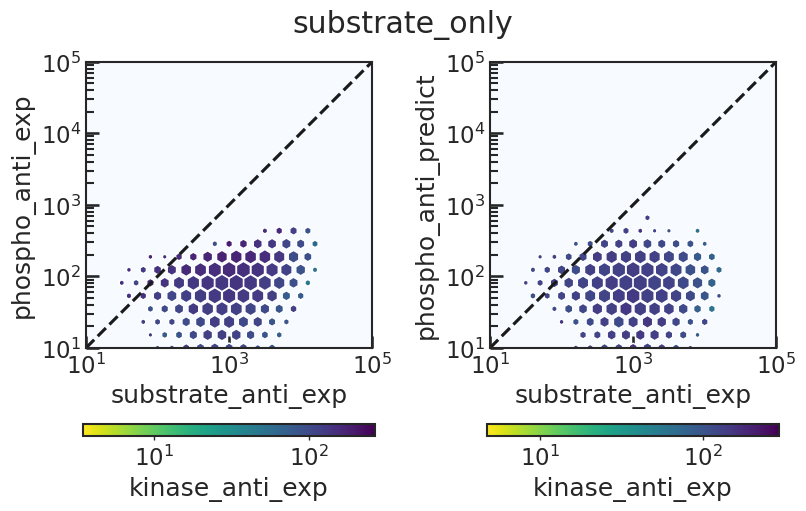

98.750374 39919.46875
2.074218 46764.02734


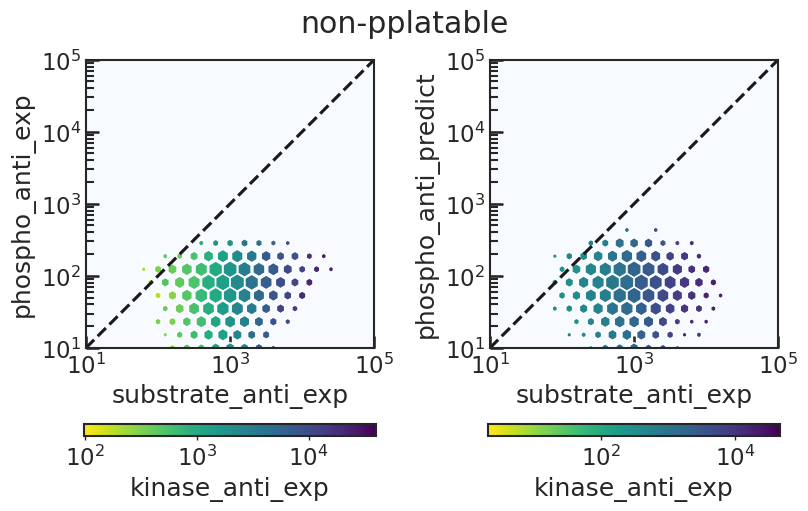

83.5931835 27738.55469
51.56422 25692.32422


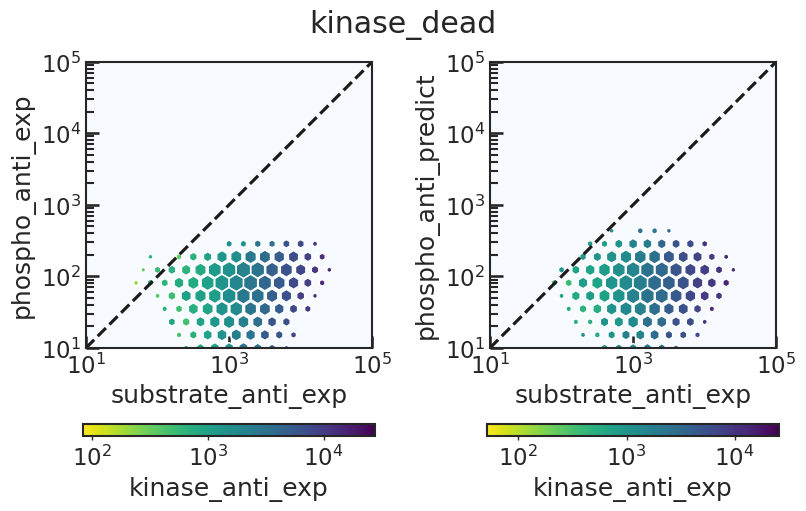

15.328974 68117.95313
15.328974 68117.95313


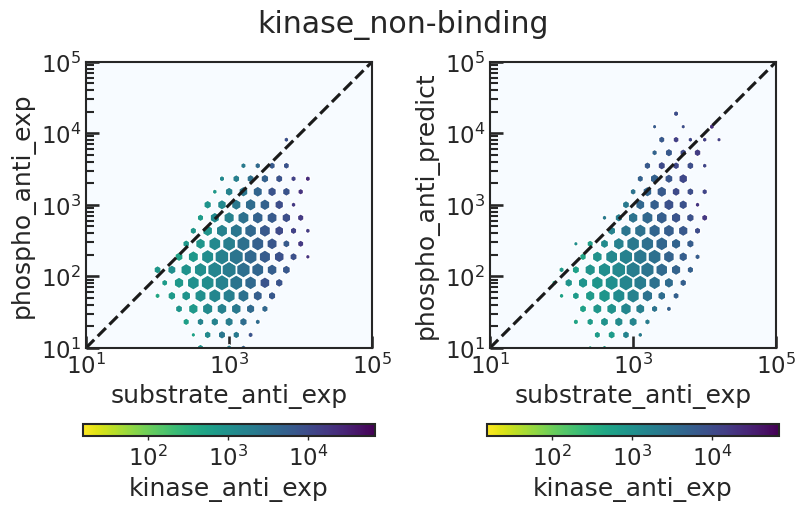

114.006218 39786.82422
66.800354 40572.35872333333


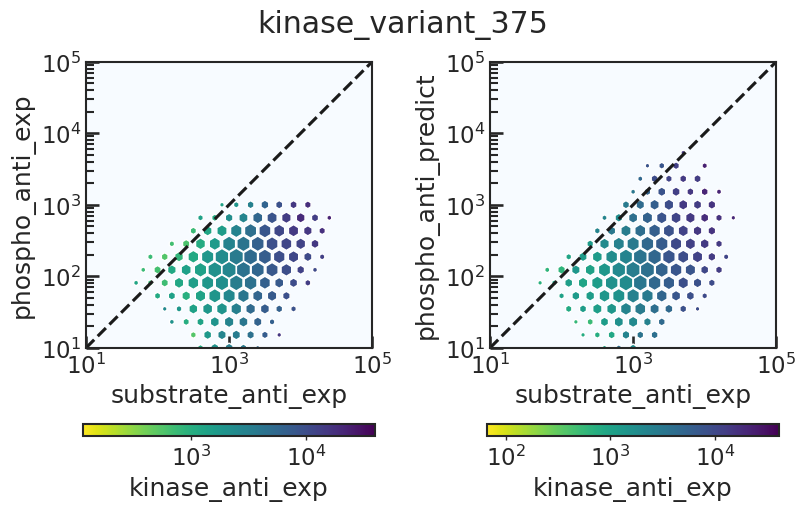

45.592781 45358.49219
28.324051 40540.24609


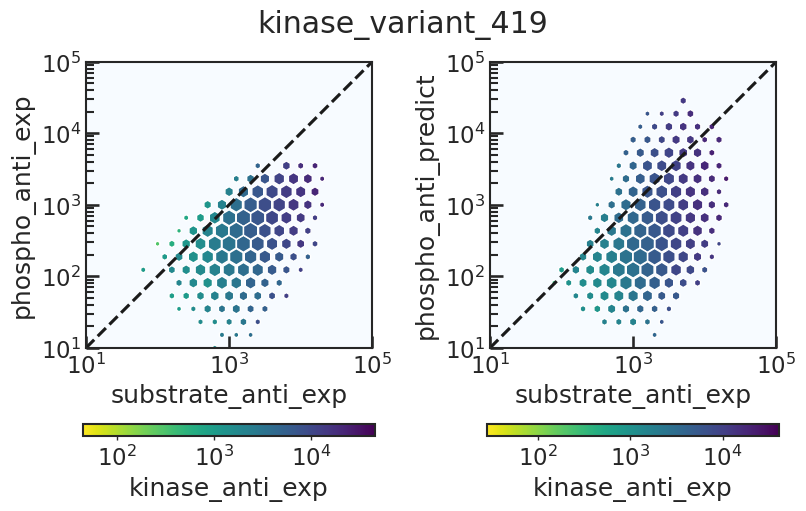

69.014359 44566.01953
73.146973 50171.91406


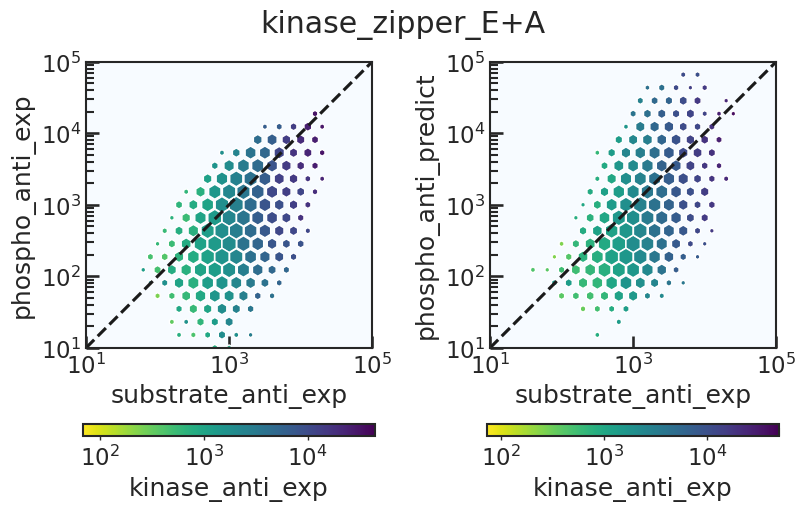

56.082577 45581.351559999996
76.63237 52986.01953


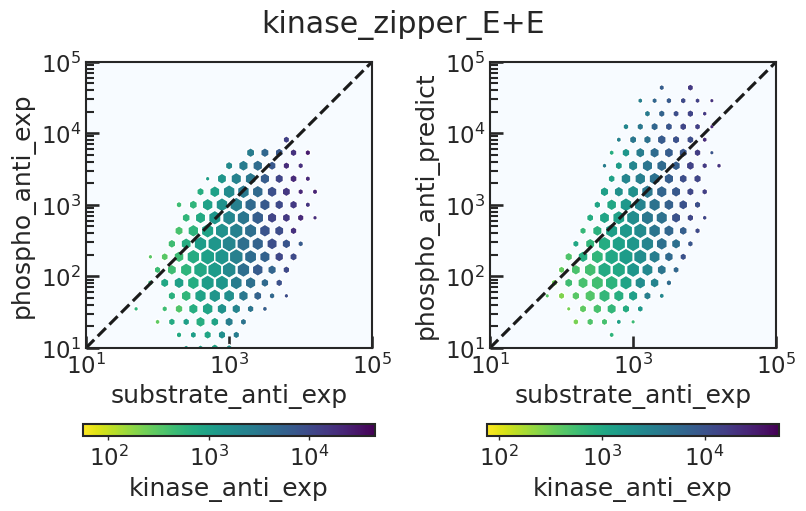

25.415079 77146.49414
33.12085 94459.47656


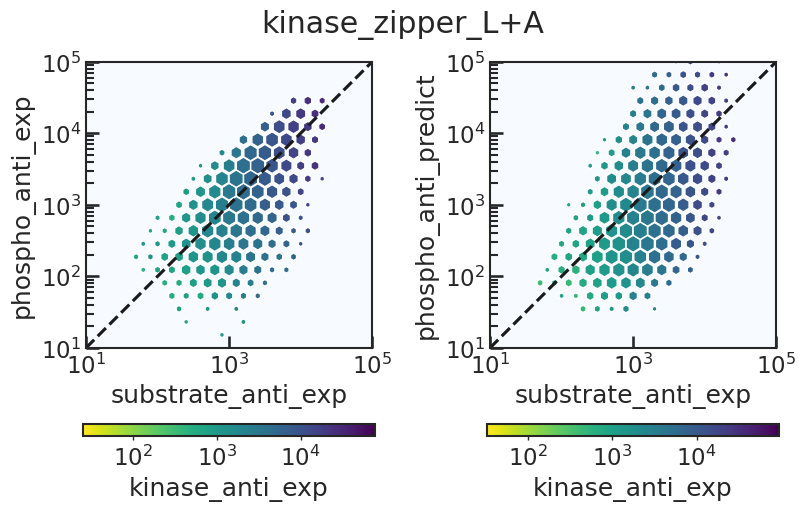

3.487823 7720.6546610000005
3.513618 7365.6477335


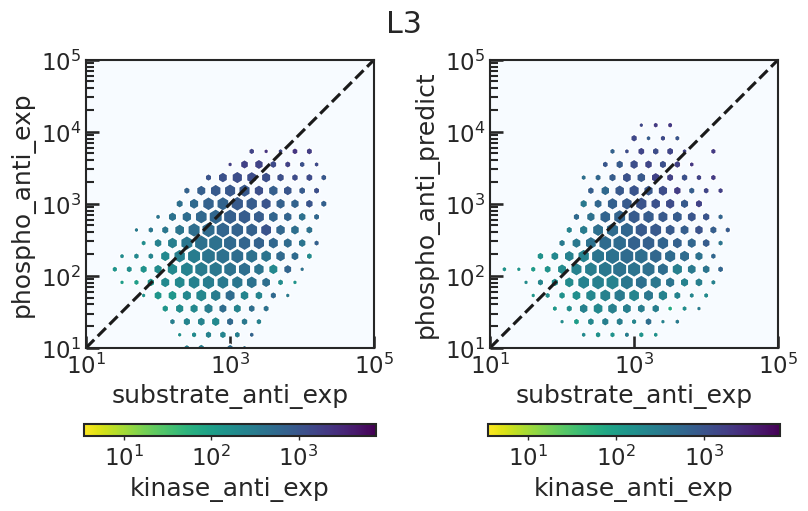

2.838418 3899.063477
14.080012 3899.063477


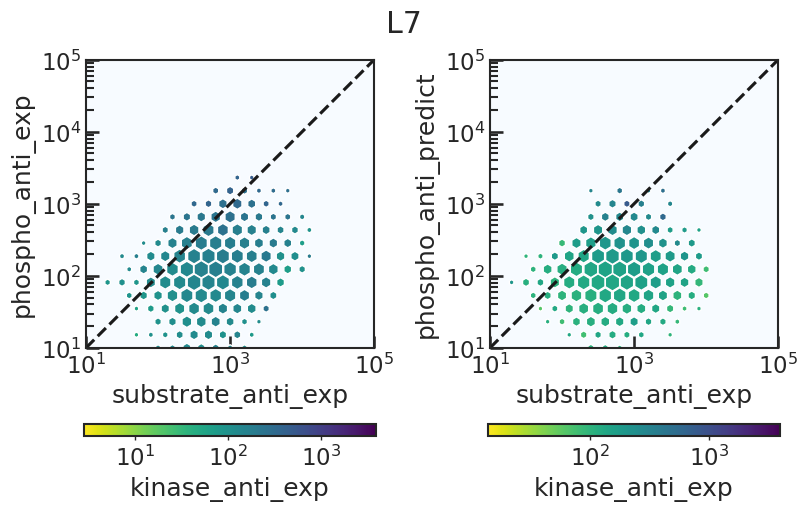

45.952309 71110.625
174.486862 79520.02344


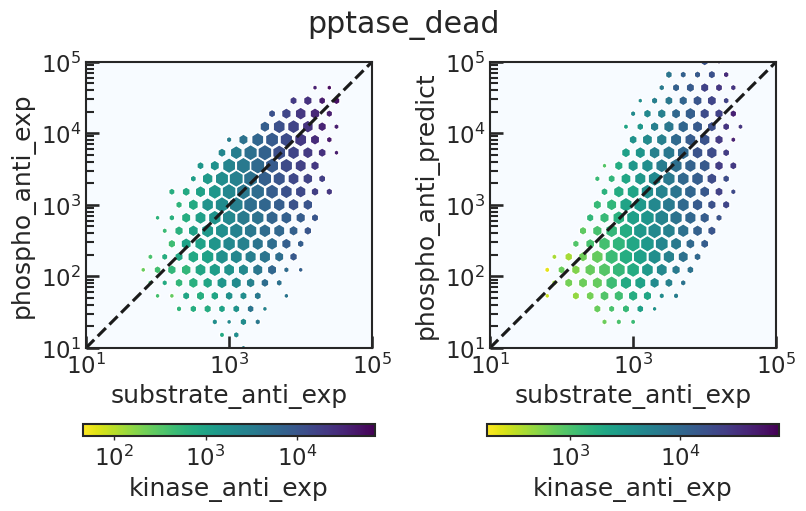

26.2477 69094.07031
118.208679 69781.58594


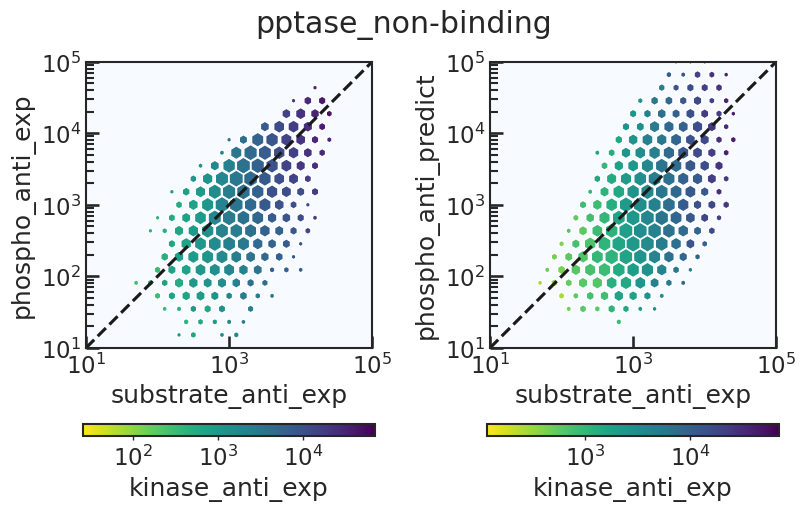

119.74667 118822.3594
34.53532 105999.269545


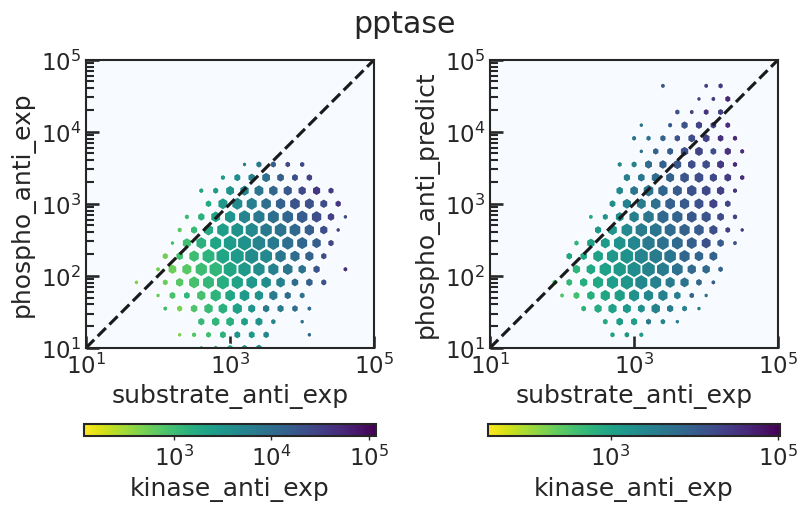

54.095844 91345.72656
77.186447 91345.72656


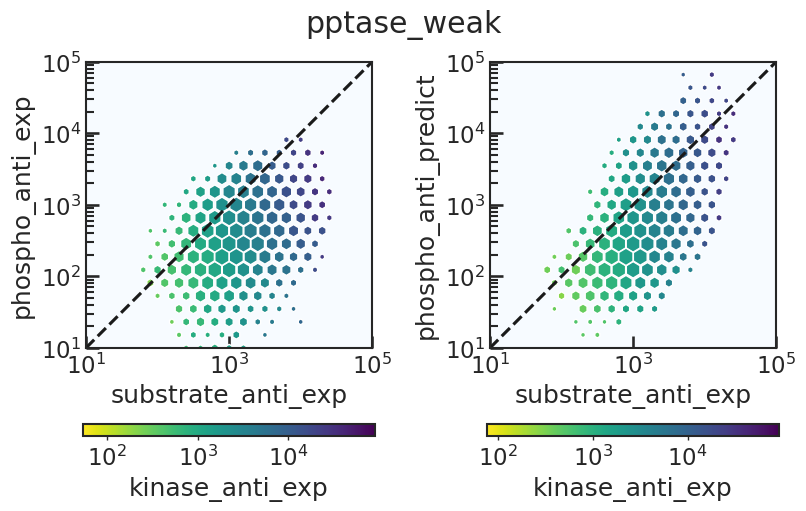

124.985321 175472.1719
109.734016 175472.1719


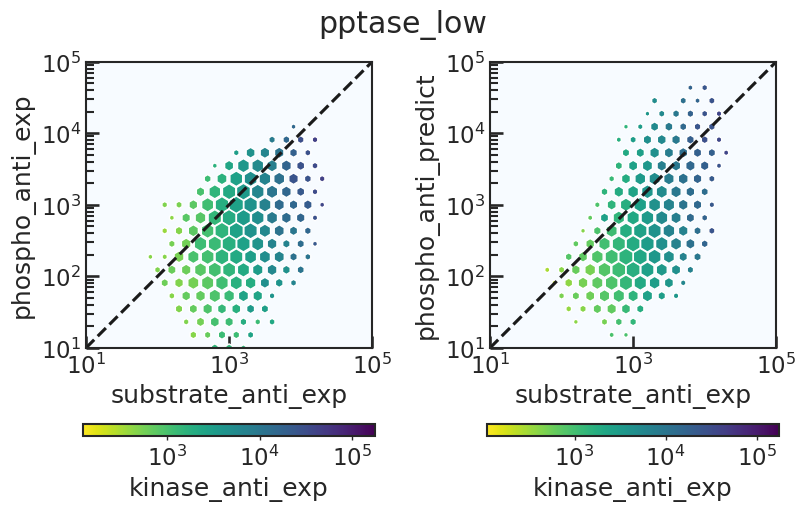

In [5]:
for exp_name, row in df_dataset_key.iterrows():
    
    df_tmp = df_data.query("exp_name==@exp_name")
    
    fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 5), squeeze=False)
    
    ##########################################################

    
    ax = axes[0, 0]
    
    fplot.plot_2d_avg_hex(df_tmp, fig, ax, 'substrate_anti_exp', 'phospho_anti_exp', 'kinase_anti_exp',  logscale=True, nbins=20, xlim=(1e1, 1e5), ylim=(1e1, 1e5), show_diagonal=True)
    
    ax = axes[0, 1]
    
    fplot.plot_2d_avg_hex(df_tmp, fig, ax, 'substrate_anti_exp', 'phospho_anti_predict', 'kinase_anti_exp',  logscale=True, nbins=20, xlim=(1e1, 1e5), ylim=(1e1, 1e5), show_diagonal=True)
    
    
    fig.suptitle(exp_name)
    
    plt.show()

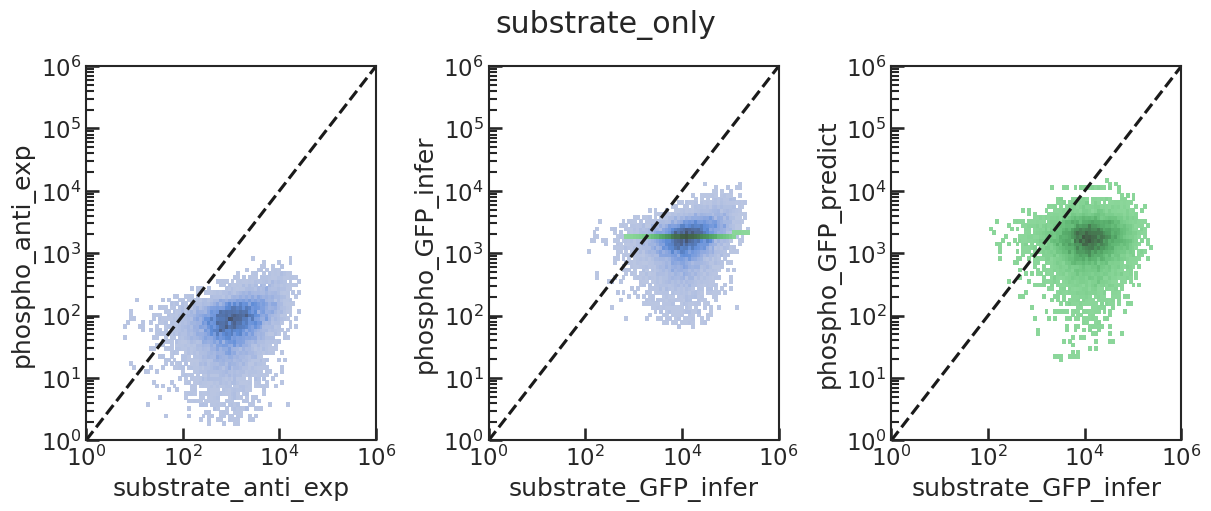

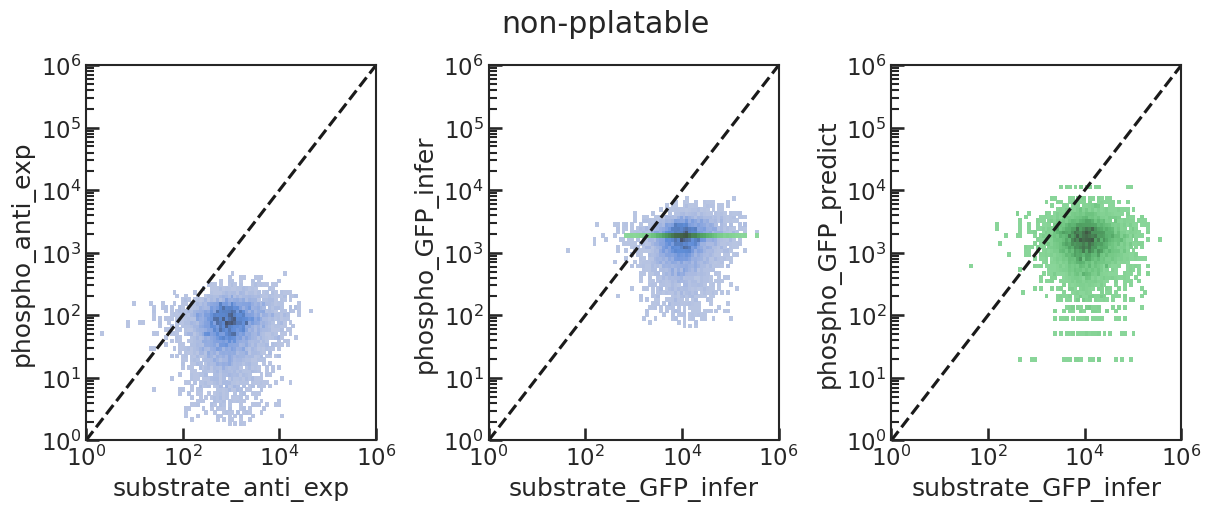

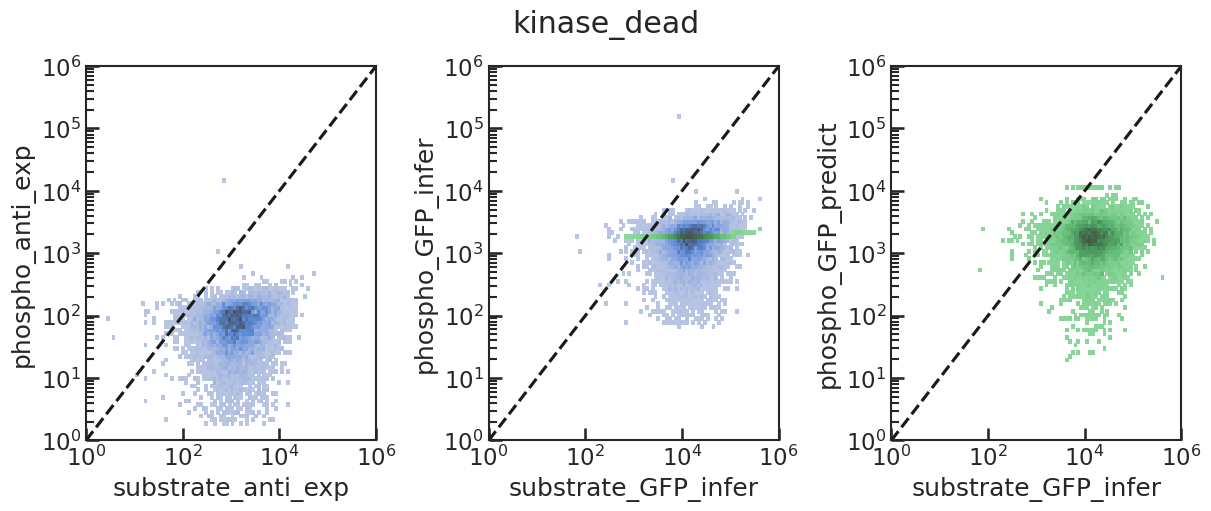

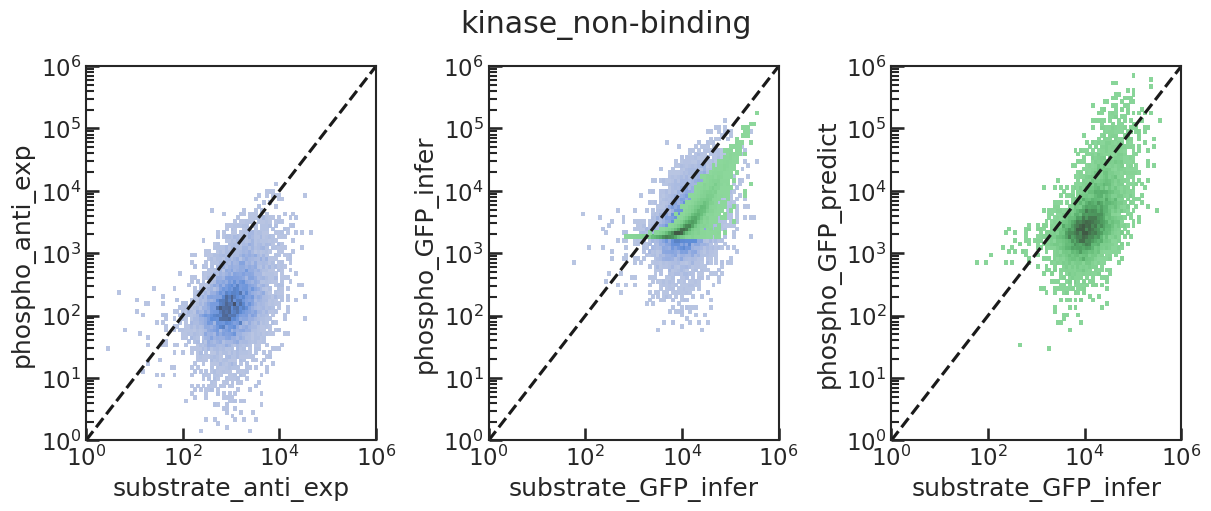

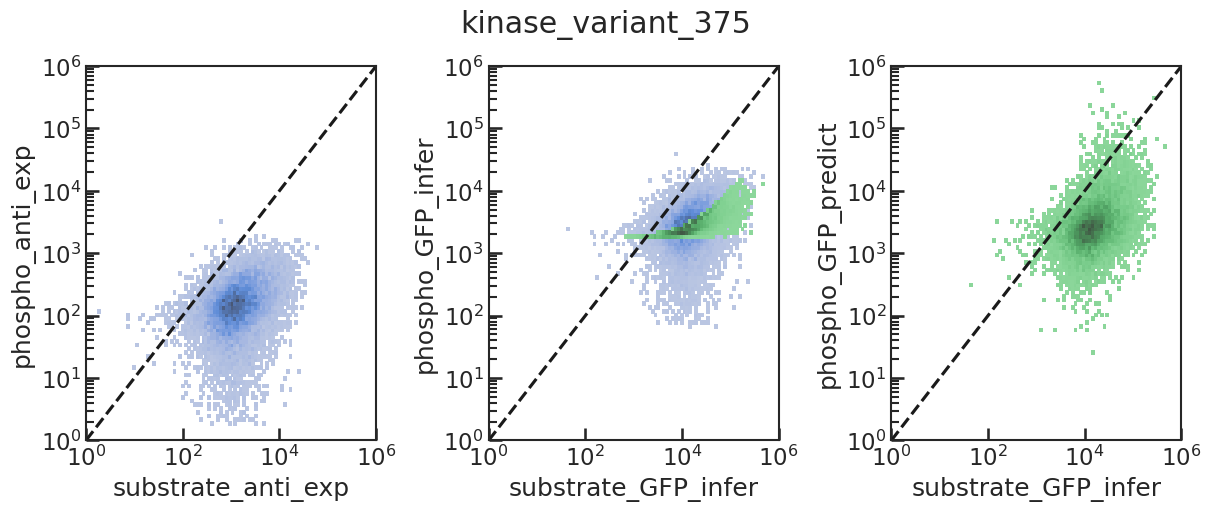

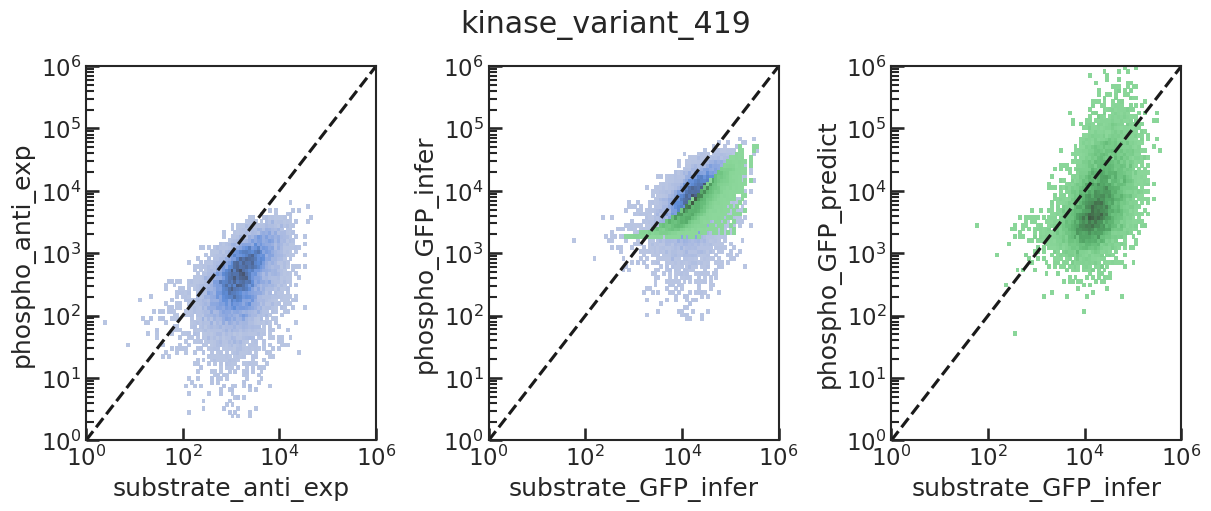

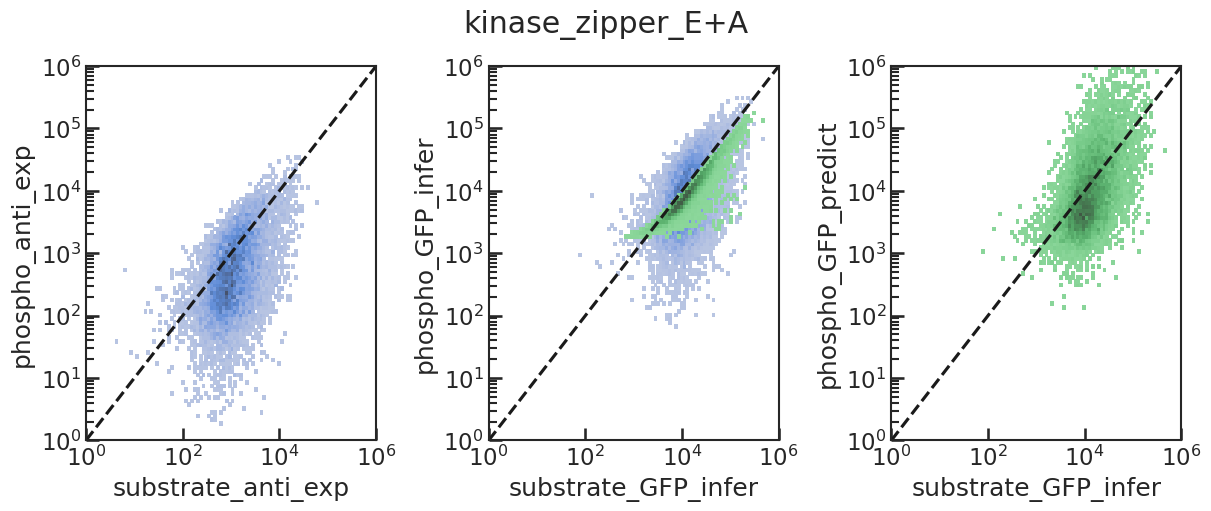

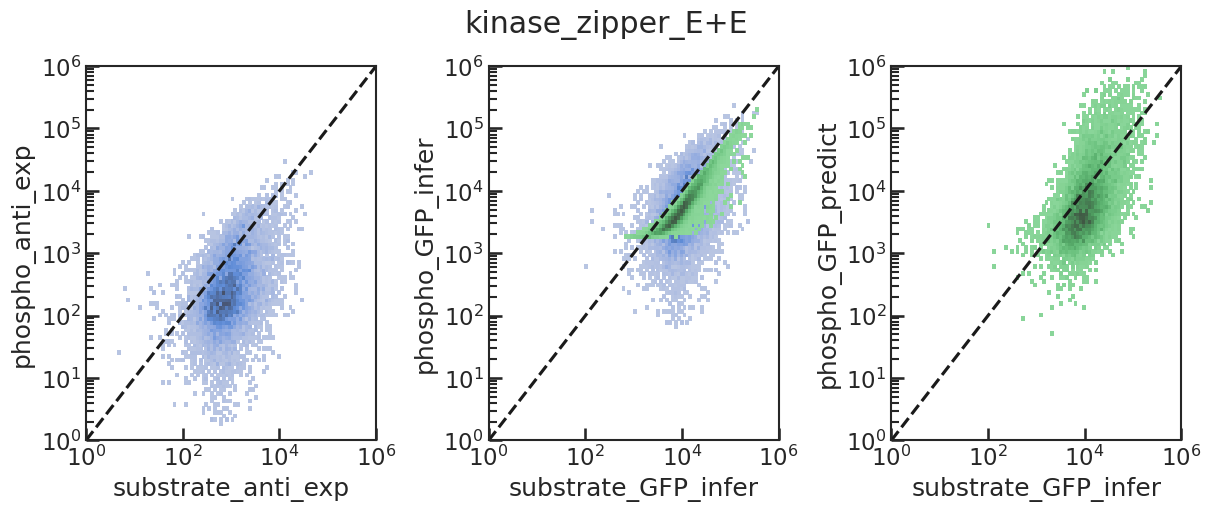

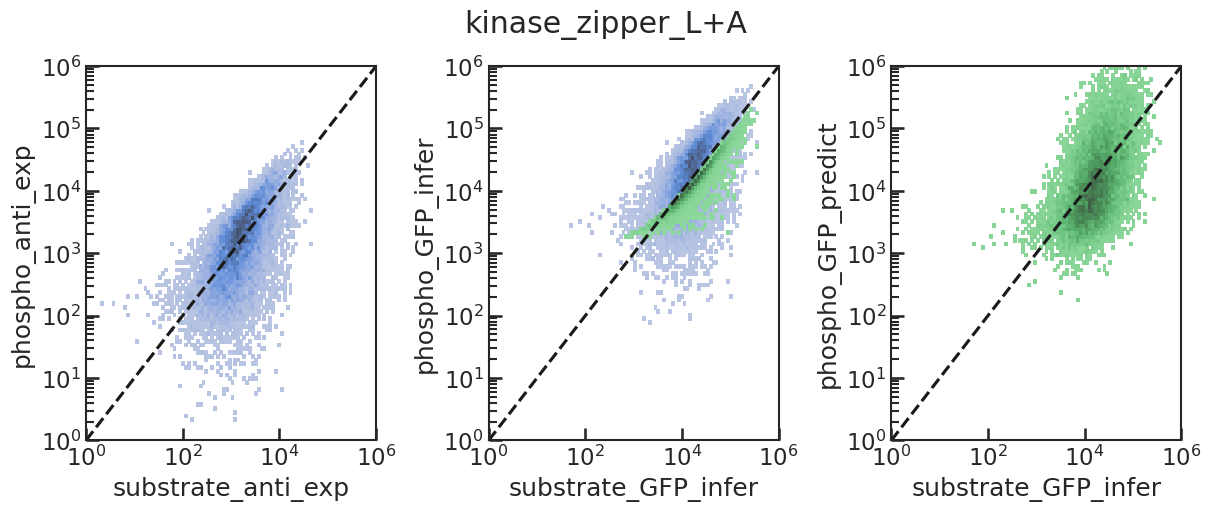

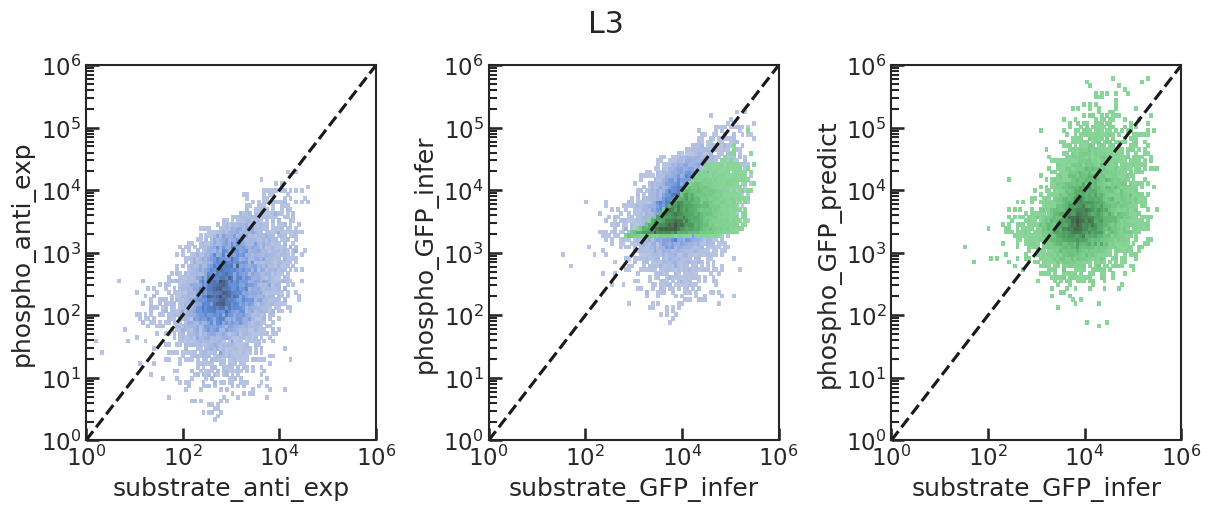

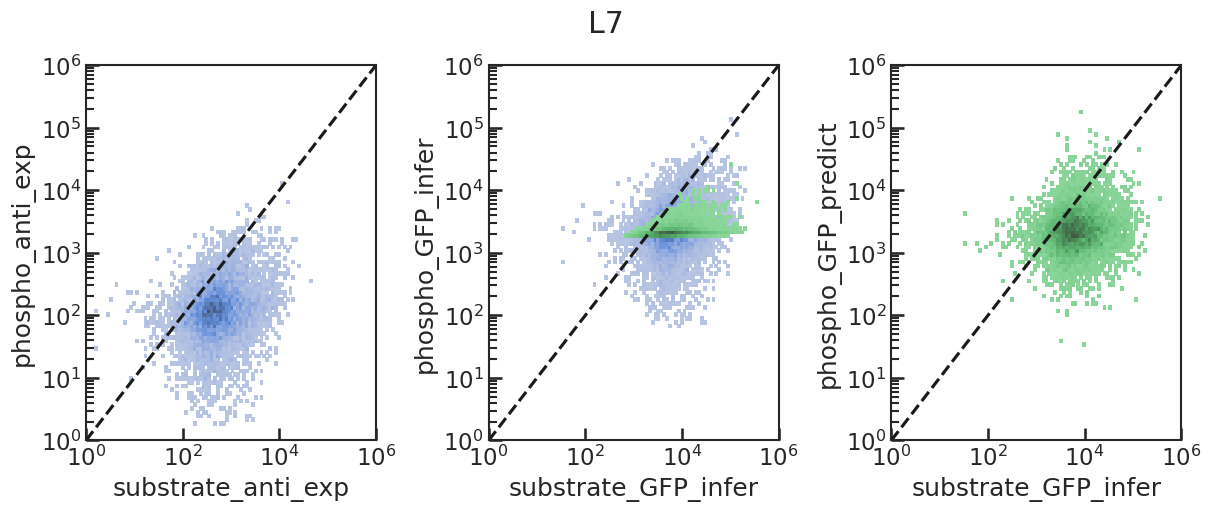

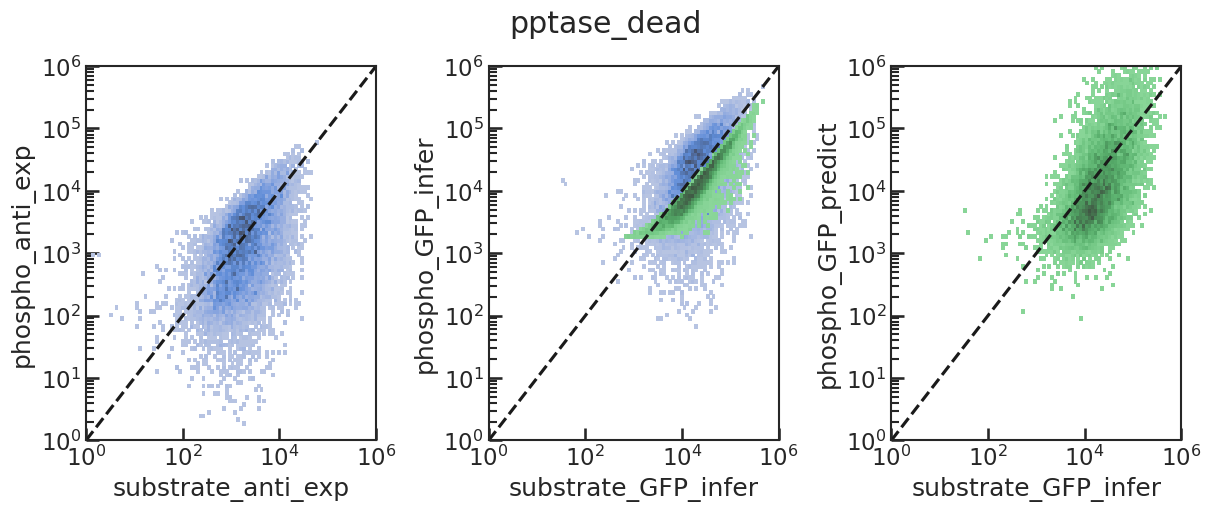

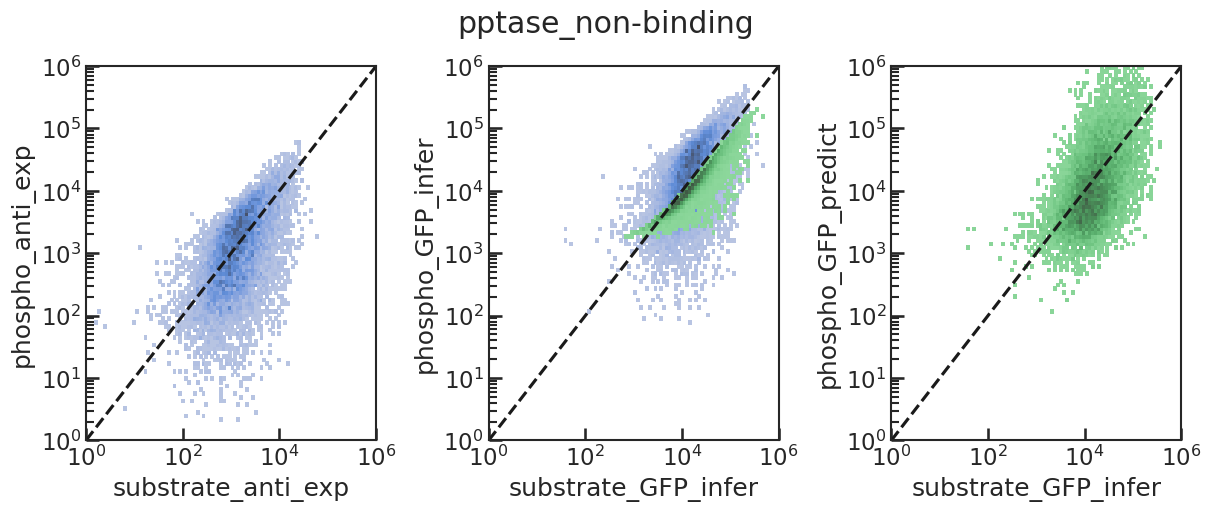

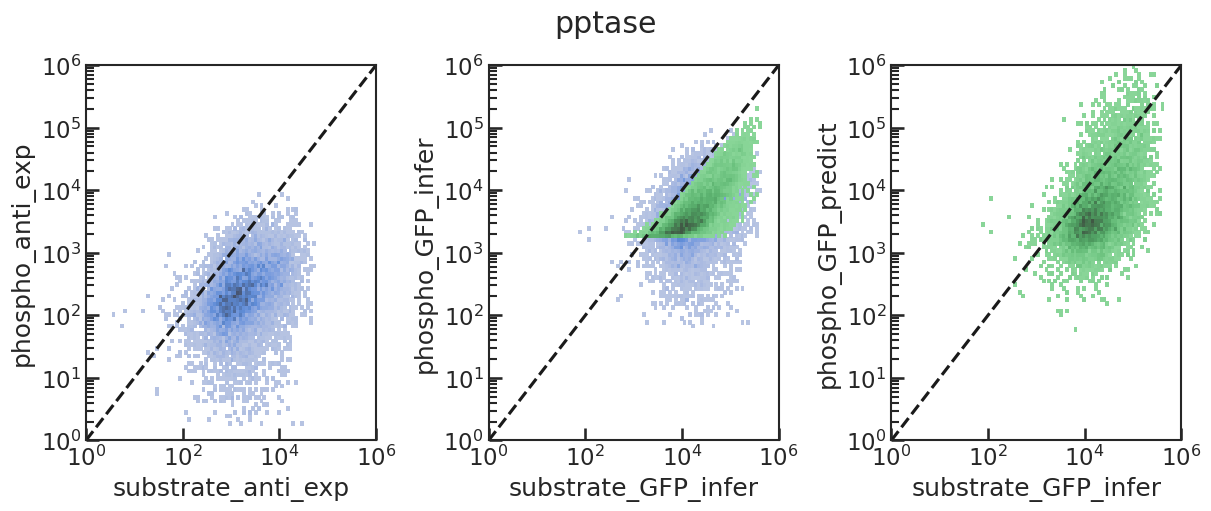

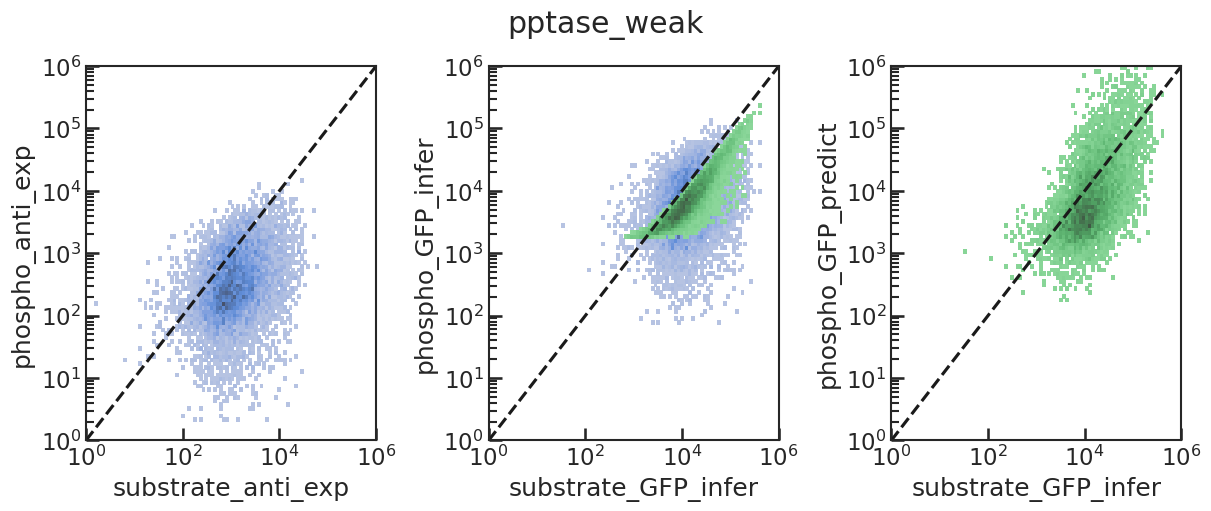

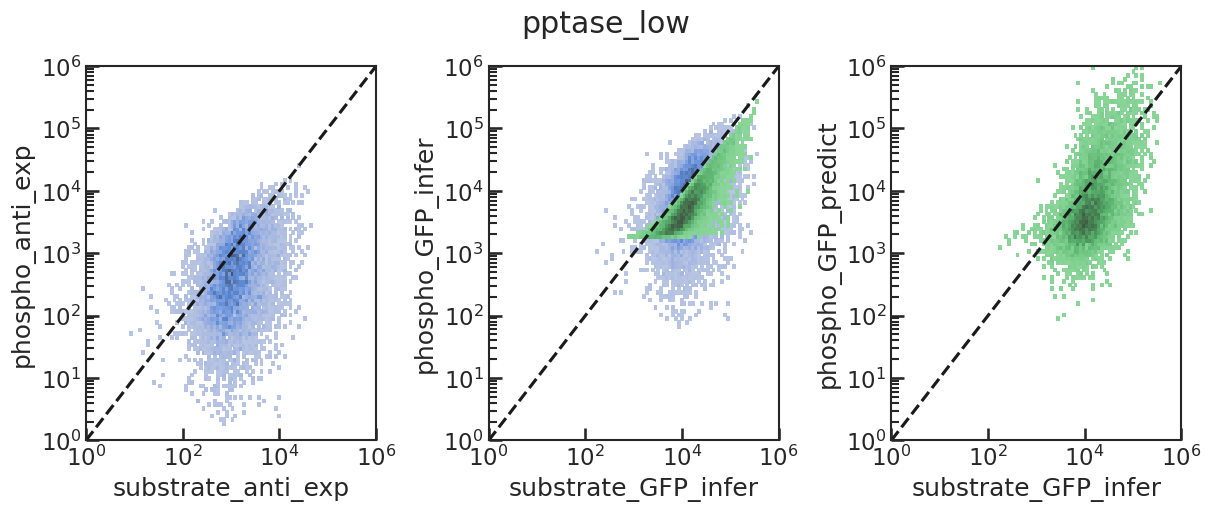

In [4]:

for exp_name, row in df_dataset_key.iterrows():
    
#     if exp_name != "kinase_zipper_L+A":
#         continue
    
    df_tmp = df_data.query("exp_name==@exp_name")
            
    fig, axes = plt.subplots(1,3, constrained_layout=True, figsize=(12, 5), squeeze=False)
    ax = axes[0, 0]
    
    sns.histplot(df_tmp, x='substrate_anti_exp', y='phospho_anti_exp', ax=ax, log_scale=(True, True), binrange=[[0, 6], [0, 6]], bins=100)
    ax.plot([1e0, 1e6], [1e0, 1e6], 'k--')
    
    ax.set_xlim(1e0, 1e6)
    ax.set_ylim(1e0, 1e6)
    
    ax = axes[0, 1]
    sns.histplot(df_tmp, x='substrate_GFP_infer', y='phospho_GFP_infer', ax=ax, log_scale=(True, True), binrange=[[0, 6], [0, 6]], bins=100)
    ax.plot([1e0, 1e6], [1e0, 1e6], 'k--')
#     ax.plot([1e0, 1e6], [2*1e0, 2*1e6], 'r--')
    sns.histplot(df_tmp, x='substrate_GFP_denoise', y='phospho_GFP_denoise', ax=ax, log_scale=(True, True), color='g', binrange=[[0, 6], [0, 6]], bins=100)

    ax.set_xlim(1e0, 1e6)
    ax.set_ylim(1e0, 1e6)
    
    ax = axes[0, 2]
    ax.plot([1e0, 1e6], [1e0, 1e6], 'k--')
    
    sns.histplot(df_tmp, x='substrate_GFP_infer', y='phospho_GFP_predict', ax=ax, log_scale=(True, True), color='g', binrange=[[0, 6], [0, 6]], bins=100)
    
    ax.set_xlim(1e0, 1e6)
    ax.set_ylim(1e0, 1e6)
    
    fig.suptitle(exp_name)
    
    plt.show()
    
#     if row['model'] == 'two_layer' or row['model'] == 'two_layer_nowriter'  or row['model'] == 'two_layer_noeraser':
        
#         fig, axes = plt.subplots(1,2, constrained_layout=True, figsize=(8, 5), squeeze=False)
#         ax = axes[0, 0]

#         sns.histplot(df_tmp, x='kinase2_GFP_infer', y='kinase2_phospho_GFP_infer', ax=ax, log_scale=(True, True), binrange=[[1, 5], [1, 5]], bins=100)
#         ax.plot([1e1, 1e5], [1e1, 1e5], 'k--')


#         ax = axes[0, 1]
#         sns.histplot(df_tmp, x='kinase2_GFP_infer', y='kinase2_phospho_GFP_infer', ax=ax, log_scale=(True, True), binrange=[[1, 5], [1, 5]], bins=100)
#         ax.plot([1e1, 1e5], [1e1, 1e5], 'k--')

#         sns.histplot(df_tmp, x='kinase2_GFP_infer', y='kinase2_phospho_GFP_predict', ax=ax, log_scale=(True, True), color='g', binrange=[[1, 5], [1, 5]], bins=100)

#         fig.suptitle(exp_name)

#         plt.show()


    